# Injury Prediction In Mining Industry Through Applied Machine learning case study 3

Student name: Akash MAnjunatha
student ID: x21141797

# Step1  Understanding the Data and loading from the TXT file using Pyspark

In [2]:
#Mounting drive data to Google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 57.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=51833969b231ad62cb1043533f599df0b9467e52faacbedc7cf7b40f1fed8405
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [4]:
#installing all required packages for the project
from numpy import where
import numpy as np
import pandas as pd
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from time import time
from packaging import version
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import SGDClassifier
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from pylab import *
from scipy.special import boxcox1p

from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor






#installing the pyspark packages for the further analysis
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import *

In [5]:
#creating the spark session with required configurations
spark = SparkSession.builder.appName("myApp").getOrCreate()

In [6]:
#fetching the accident data from the txt file.

df_accident =  spark.read.format("csv").option("delimiter","|").option("header","true").load('/content/gdrive/My Drive/Accidents.txt')

In [7]:
#displaying the data featched
df_accident.show()

+-------+-------------+--------------------+-----------+--------------------+-------------+------------+----------+--------------------+-----------+------+-------+---------+----------+-------------+----------------+--------------------+-------------+--------------+--------------+-------------------+----------------+---------------+--------------------+------------+--------------+--------------+----------------+-----------------+--------------------+----------------+--------------------+-----------+---------+----------+---------+-------------+--------------------+-----------+--------------------+----------------+--------------------+----------------+--------------------+----------------+--------------------+---------------+-------------+---------+----------+-----------------+---------------+--------------+---------------+--------------------+-------------+--------------+
|MINE_ID|CONTROLLER_ID|     CONTROLLER_NAME|OPERATOR_ID|       OPERATOR_NAME|CONTRACTOR_ID| DOCUMENT_NO|SUBUNIT_CD|  

In [8]:
#retaining only the required columns after analyzing

df_accident = df_accident.select("MINE_ID","SUBUNIT_CD","ACCIDENT_DT","CAL_YR","CAL_QTR","FISCAL_YR","FISCAL_QTR","ACCIDENT_TIME","DEGREE_INJURY_CD","FIPS_STATE_CD","UG_LOCATION_CD","UG_MINING_METHOD_CD","MINING_EQUIP_CD","SHIFT_BEGIN_TIME","CLASSIFICATION_CD","ACCIDENT_TYPE_CD","NO_INJURIES","TOT_EXPER","MINE_EXPER","JOB_EXPER","OCCUPATION_CD","ACTIVITY_CD","INJURY_SOURCE_CD","NATURE_INJURY_CD","INJ_BODY_PART_CD","DAYS_RESTRICT","DAYS_LOST","TRANS_TERM","COAL_METAL_IND","CLASSIFICATION", "ACCIDENT_TYPE", "NATURE_INJURY", "INJ_BODY_PART")

In [9]:
df_accident.select("DEGREE_INJURY_CD").distinct().show()

+----------------+
|DEGREE_INJURY_CD|
+----------------+
|              07|
|              01|
|              00|
|              09|
|              05|
|              08|
|              03|
|              02|
|              06|
|              10|
|              04|
|               ?|
+----------------+



In [10]:
df_accident.count()

252085

In [11]:
#fetching the mine data from the txt file.
df_mines =  spark.read.format("csv").option("delimiter","|").option("header","true").load("/content/gdrive/My Drive/Mines.txt")

In [12]:
df_mines.show()

+-------+--------------------+--------------+-----------------+-------------------+-----------------+---------------------+-----------------------+-------------------+---------------------+-----+------------+------------+------------+------------+------------+---------------------------+--------+---------+--------------------+---------------+--------------+--------------------+----------------+------------------+----------------+--------------------+------------------+--------------------+------------------+---------------+--------------------+-----------------+--------------------+---------------+------------------+-------------------+-------------+---------------+-------------------+--------------------+------------+---------------+----------+---------+---------------+--------------------+------------------+-----------------+--------------------+----------------+--------------------+-------------------+-------------+--------------+--------------------+-----------------+--------------

In [13]:
#left joing the accident(main data) and minedata(second data)
#website: https://arlweb.msha.gov/OpenGovernmentData/OGIMSHA.asp


df_join_01 = df_accident.join(df_mines.select("MINE_ID","CURRENT_MINE_TYPE","CURRENT_MINE_STATUS","PRIMARY_CANVASS_CD","LONGITUDE","LATITUDE"),["MINE_ID"],how="left")

In [14]:
df_join_01.show()

+-------+----------+-----------+------+-------+---------+----------+-------------+----------------+-------------+--------------+-------------------+---------------+----------------+-----------------+----------------+-----------+---------+----------+---------+-------------+-----------+----------------+----------------+----------------+-------------+---------+----------+--------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+------------------+----------+---------+
|MINE_ID|SUBUNIT_CD|ACCIDENT_DT|CAL_YR|CAL_QTR|FISCAL_YR|FISCAL_QTR|ACCIDENT_TIME|DEGREE_INJURY_CD|FIPS_STATE_CD|UG_LOCATION_CD|UG_MINING_METHOD_CD|MINING_EQUIP_CD|SHIFT_BEGIN_TIME|CLASSIFICATION_CD|ACCIDENT_TYPE_CD|NO_INJURIES|TOT_EXPER|MINE_EXPER|JOB_EXPER|OCCUPATION_CD|ACTIVITY_CD|INJURY_SOURCE_CD|NATURE_INJURY_CD|INJ_BODY_PART_CD|DAYS_RESTRICT|DAYS_LOST|TRANS_TERM|COAL_METAL_IND|      CLASSIFICATION|       ACCIDENT_TYPE|       NATURE_INJURY|  

In [15]:
df_join_01.printSchema()

root
 |-- MINE_ID: string (nullable = true)
 |-- SUBUNIT_CD: string (nullable = true)
 |-- ACCIDENT_DT: string (nullable = true)
 |-- CAL_YR: string (nullable = true)
 |-- CAL_QTR: string (nullable = true)
 |-- FISCAL_YR: string (nullable = true)
 |-- FISCAL_QTR: string (nullable = true)
 |-- ACCIDENT_TIME: string (nullable = true)
 |-- DEGREE_INJURY_CD: string (nullable = true)
 |-- FIPS_STATE_CD: string (nullable = true)
 |-- UG_LOCATION_CD: string (nullable = true)
 |-- UG_MINING_METHOD_CD: string (nullable = true)
 |-- MINING_EQUIP_CD: string (nullable = true)
 |-- SHIFT_BEGIN_TIME: string (nullable = true)
 |-- CLASSIFICATION_CD: string (nullable = true)
 |-- ACCIDENT_TYPE_CD: string (nullable = true)
 |-- NO_INJURIES: string (nullable = true)
 |-- TOT_EXPER: string (nullable = true)
 |-- MINE_EXPER: string (nullable = true)
 |-- JOB_EXPER: string (nullable = true)
 |-- OCCUPATION_CD: string (nullable = true)
 |-- ACTIVITY_CD: string (nullable = true)
 |-- INJURY_SOURCE_CD: string

In [16]:
#making duplicate

df_input = df_join_01

In [17]:
#total number of rows
df_input.count()

252085

In [18]:
df_input.show()

+-------+----------+-----------+------+-------+---------+----------+-------------+----------------+-------------+--------------+-------------------+---------------+----------------+-----------------+----------------+-----------+---------+----------+---------+-------------+-----------+----------------+----------------+----------------+-------------+---------+----------+--------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+------------------+----------+---------+
|MINE_ID|SUBUNIT_CD|ACCIDENT_DT|CAL_YR|CAL_QTR|FISCAL_YR|FISCAL_QTR|ACCIDENT_TIME|DEGREE_INJURY_CD|FIPS_STATE_CD|UG_LOCATION_CD|UG_MINING_METHOD_CD|MINING_EQUIP_CD|SHIFT_BEGIN_TIME|CLASSIFICATION_CD|ACCIDENT_TYPE_CD|NO_INJURIES|TOT_EXPER|MINE_EXPER|JOB_EXPER|OCCUPATION_CD|ACTIVITY_CD|INJURY_SOURCE_CD|NATURE_INJURY_CD|INJ_BODY_PART_CD|DAYS_RESTRICT|DAYS_LOST|TRANS_TERM|COAL_METAL_IND|      CLASSIFICATION|       ACCIDENT_TYPE|       NATURE_INJURY|  

# STEP2: Exploration of the data and Data Preparation (preliminary cleaning and feature engineering

In [19]:
#since the data has lot of missing values and ? values removing all those and make it null for further analysis

from pyspark.sql.functions import *
df_01 = df_input.select([when(col(c)=="?",None).otherwise(col(c)).alias(c) for c in df_input.columns])
df_01.show()

+-------+----------+-----------+------+-------+---------+----------+-------------+----------------+-------------+--------------+-------------------+---------------+----------------+-----------------+----------------+-----------+---------+----------+---------+-------------+-----------+----------------+----------------+----------------+-------------+---------+----------+--------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+------------------+----------+---------+
|MINE_ID|SUBUNIT_CD|ACCIDENT_DT|CAL_YR|CAL_QTR|FISCAL_YR|FISCAL_QTR|ACCIDENT_TIME|DEGREE_INJURY_CD|FIPS_STATE_CD|UG_LOCATION_CD|UG_MINING_METHOD_CD|MINING_EQUIP_CD|SHIFT_BEGIN_TIME|CLASSIFICATION_CD|ACCIDENT_TYPE_CD|NO_INJURIES|TOT_EXPER|MINE_EXPER|JOB_EXPER|OCCUPATION_CD|ACTIVITY_CD|INJURY_SOURCE_CD|NATURE_INJURY_CD|INJ_BODY_PART_CD|DAYS_RESTRICT|DAYS_LOST|TRANS_TERM|COAL_METAL_IND|      CLASSIFICATION|       ACCIDENT_TYPE|       NATURE_INJURY|  

In [20]:
df_01.select("DEGREE_INJURY_CD").distinct().show()

+----------------+
|DEGREE_INJURY_CD|
+----------------+
|              07|
|              01|
|            null|
|              00|
|              09|
|              05|
|              08|
|              03|
|              02|
|              06|
|              10|
|              04|
+----------------+



In [21]:
#duplicating data frame for further analysis

df_02 = df_01

# converting the target variables for case study 3
# category 1 and 2 = 1 fatality
# category 3 and 4 = 4 Non-fatal with days lost only
# category 5 and 6 = 6 Non-fatal with restricted work

In [22]:
#conversion 03 to 04 for analysis

df_03 = df_02.withColumn("DEGREE_INJURY_CD", when(df_02.DEGREE_INJURY_CD == '03', '04').otherwise(df_02.DEGREE_INJURY_CD))

In [23]:
#conversion 05 to 06 for analysis
df_03 = df_03.withColumn("DEGREE_INJURY_CD", when(df_03.DEGREE_INJURY_CD == '05', '06').otherwise(df_03.DEGREE_INJURY_CD))

In [24]:
#conversion 02 to 01 for analysis
df_03 = df_03.withColumn("DEGREE_INJURY_CD", when(df_03.DEGREE_INJURY_CD == '02', '01').otherwise(df_03.DEGREE_INJURY_CD))

In [25]:
#our target variable is degree of injury, and main goal of the case study is to injury to mutiple cause, 
#1 and 2 are merged and added to case study 2 categories, for this category 0,7,8,9,10 are removed

df_03 = df_03.filter(~col("DEGREE_INJURY_CD").isin(['07',"08","09","10","00","null"]))

In [26]:
#unique values after removing the unwated target rows

df_03.select("DEGREE_INJURY_CD").distinct().show()

+----------------+
|DEGREE_INJURY_CD|
+----------------+
|              01|
|              06|
|              04|
+----------------+



In [27]:
df_03.count()

209017

In [28]:
#check the shift begin time 

df_03.select("SHIFT_BEGIN_TIME").distinct().printSchema()

root
 |-- SHIFT_BEGIN_TIME: string (nullable = true)



In [29]:
#shift begin time has a values like 9999 which make no sense in terms of time, we will loose only few columns so those 
#are removed for the further analysis


df_03 = df_03.withColumn("SHIFT_BEGIN_TIME", df_03["SHIFT_BEGIN_TIME"].cast(IntegerType()))

In [30]:
df_03.select("SHIFT_BEGIN_TIME").distinct().printSchema()

root
 |-- SHIFT_BEGIN_TIME: integer (nullable = true)



In [31]:
#after preliminary analysis removing the wrong entries rows above 24:00 
df_03.select("SHIFT_BEGIN_TIME").filter(col("SHIFT_BEGIN_TIME")>2400).show()

+----------------+
|SHIFT_BEGIN_TIME|
+----------------+
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
|            9999|
+----------------+
only showing top 20 rows



In [32]:
df_03 = df_03.filter(col("SHIFT_BEGIN_TIME")<=2400)

In [33]:
df_03.count()

205250

In [34]:
#convert the shift begin time to three shifts as they are repeating frequently(morning, evening and night shift)
#7am,#3pm,#11pm

########check this can be converted to 3 labels or categories later on######

df_03 = df_03.withColumn("SHIFT_BEGIN_TIME", when((col("SHIFT_BEGIN_TIME")>=301) & (col("SHIFT_BEGIN_TIME")<=1200),lit(700)).when((col("SHIFT_BEGIN_TIME")>=1101) & (col("SHIFT_BEGIN_TIME")<=1800),lit(1500)).otherwise((lit(2300)))) 

In [35]:
#check the unique values
df_03.select("SHIFT_BEGIN_TIME").distinct().show()

+----------------+
|SHIFT_BEGIN_TIME|
+----------------+
|            1500|
|            2300|
|             700|
+----------------+



In [36]:
df_03.select("ACCIDENT_TIME").distinct().printSchema()

root
 |-- ACCIDENT_TIME: string (nullable = true)



In [37]:
df_04 = df_03.withColumn("ACCIDENT_TIME", df_03["ACCIDENT_TIME"].cast(IntegerType()))

In [38]:
#almost 10k rows of data loss if we remove the outlier of ACCIDENT_TIME, insted those time are converted accorinding to the shift begin as it correlates with the accident time 


df_04 = df_04.withColumn("ACCIDENT_TIME_NEW",when(col("ACCIDENT_TIME")>2400,col("SHIFT_BEGIN_TIME")).otherwise(col("ACCIDENT_TIME")))

In [39]:
df_04.select("ACCIDENT_TIME_NEW","ACCIDENT_TIME").show()

+-----------------+-------------+
|ACCIDENT_TIME_NEW|ACCIDENT_TIME|
+-----------------+-------------+
|             1815|         1815|
|              900|          900|
|              800|          800|
|             1600|         1600|
|              540|          540|
|             1245|         1245|
|             1000|         1000|
|             1230|         1230|
|             2200|         2200|
|             1320|         1320|
|             1500|         1500|
|             1445|         1445|
|              945|          945|
|             1700|         1700|
|              700|         9999|
|             1430|         1430|
|             1100|         1100|
|              730|          730|
|             1230|         1230|
|             1245|         1245|
+-----------------+-------------+
only showing top 20 rows



In [40]:
#converting rest of the rows to three frequent time as explained above

df_04 = df_04.withColumn("ACCIDENT_TIME_NEW", when((col("ACCIDENT_TIME_NEW")>=301) & (col("ACCIDENT_TIME_NEW")<=1200),lit(700)).when((col("ACCIDENT_TIME_NEW")>=1101) & (col("ACCIDENT_TIME_NEW")<=1800),lit(1500)).otherwise((lit(2300))))

In [41]:
df_04.select("ACCIDENT_TIME_NEW","ACCIDENT_TIME").show()

+-----------------+-------------+
|ACCIDENT_TIME_NEW|ACCIDENT_TIME|
+-----------------+-------------+
|             2300|         1815|
|              700|          900|
|              700|          800|
|             1500|         1600|
|              700|          540|
|             1500|         1245|
|              700|         1000|
|             1500|         1230|
|             2300|         2200|
|             1500|         1320|
|             1500|         1500|
|             1500|         1445|
|              700|          945|
|             1500|         1700|
|              700|         9999|
|             1500|         1430|
|              700|         1100|
|              700|          730|
|             1500|         1230|
|             1500|         1245|
+-----------------+-------------+
only showing top 20 rows



In [42]:
#drop the column ACCIDENT_TIME and rename to the old for further analysis
#................

df_04 = df_04.drop("ACCIDENT_TIME") 

In [43]:
df_04 = df_04.withColumnRenamed("ACCIDENT_TIME_NEW","ACCIDENT_TIME")
df_04.printSchema()

root
 |-- MINE_ID: string (nullable = true)
 |-- SUBUNIT_CD: string (nullable = true)
 |-- ACCIDENT_DT: string (nullable = true)
 |-- CAL_YR: string (nullable = true)
 |-- CAL_QTR: string (nullable = true)
 |-- FISCAL_YR: string (nullable = true)
 |-- FISCAL_QTR: string (nullable = true)
 |-- DEGREE_INJURY_CD: string (nullable = true)
 |-- FIPS_STATE_CD: string (nullable = true)
 |-- UG_LOCATION_CD: string (nullable = true)
 |-- UG_MINING_METHOD_CD: string (nullable = true)
 |-- MINING_EQUIP_CD: string (nullable = true)
 |-- SHIFT_BEGIN_TIME: integer (nullable = false)
 |-- CLASSIFICATION_CD: string (nullable = true)
 |-- ACCIDENT_TYPE_CD: string (nullable = true)
 |-- NO_INJURIES: string (nullable = true)
 |-- TOT_EXPER: string (nullable = true)
 |-- MINE_EXPER: string (nullable = true)
 |-- JOB_EXPER: string (nullable = true)
 |-- OCCUPATION_CD: string (nullable = true)
 |-- ACTIVITY_CD: string (nullable = true)
 |-- INJURY_SOURCE_CD: string (nullable = true)
 |-- NATURE_INJURY_CD: s

In [44]:
#office workers were excluded from analyses by excluding both employee hours and 
#injuries reported for office locations (MSHA subunit code = 99). 

df_05 = df_04.filter(col("SUBUNIT_CD")!="99")

In [45]:
#row count

df_05.count()

204111

In [46]:
#unique values in the subunit
df_05.select("SUBUNIT_CD").distinct().show()

+----------+
|SUBUNIT_CD|
+----------+
|        30|
|        01|
|        17|
|        05|
|        03|
|        02|
|        06|
|        12|
|        04|
+----------+



In [47]:
#featureing engineering the total experience check for the unique values

df_03.select("TOT_EXPER").show()

+---------+
|TOT_EXPER|
+---------+
|        1|
|       35|
|    20.23|
|    23.69|
|    36.85|
|     null|
|       26|
|     1.08|
|     5.52|
|        7|
|       .9|
|     2.08|
|     9.77|
|       30|
|      .06|
|      .08|
|        3|
|    27.23|
|     6.56|
|     1.44|
+---------+
only showing top 20 rows



In [48]:

#converting total exp into 7 labels so it will be easy for the predic and viz and seeing the patterns 

df_05 = df_05.withColumn("tot_expr_01",when(((col("TOT_EXPER")>=0) & (col("TOT_EXPER")<1)) | (col("TOT_EXPER") == "null") ,lit("0-1")).when((col("TOT_EXPER")>=1) & (col("TOT_EXPER")<3),lit("1-3")).when((col("TOT_EXPER")>=3) & (col("TOT_EXPER")<6),lit("3-6")).when((col("TOT_EXPER")>=6) & (col("TOT_EXPER")<10),lit("6-10")).when((col("TOT_EXPER")>=10) & (col("TOT_EXPER")<20),lit("10-20")).when((col("TOT_EXPER")>=20) & (col("TOT_EXPER")<30),lit("20-30")).otherwise(lit("30+")))

In [49]:
df_05.select("tot_expr_01").distinct().show()

+-----------+
|tot_expr_01|
+-----------+
|      20-30|
|       6-10|
|        1-3|
|        0-1|
|      10-20|
|        3-6|
|        30+|
+-----------+



In [50]:
#aftermath of the conversion, unique values #self explinatory 
df_05.select("tot_expr_01").distinct().show()

+-----------+
|tot_expr_01|
+-----------+
|      20-30|
|       6-10|
|        1-3|
|        0-1|
|      10-20|
|        3-6|
|        30+|
+-----------+



In [51]:
 #converting total MINE_EXPER_01 into 7 labels so it will be easy for the predic and viz and seeing the patterns 
df_06 = df_05.withColumn("MINE_EXPER_01",when(((col("MINE_EXPER")>=0) & (col("MINE_EXPER")<1)) | (col("MINE_EXPER") == "null") ,lit("0-1")).when((col("MINE_EXPER")>=1) & (col("MINE_EXPER")<3),lit("1-3")).when((col("MINE_EXPER")>=3) & (col("MINE_EXPER")<6),lit("3-6")).when((col("MINE_EXPER")>=6) & (col("MINE_EXPER")<10),lit("6-10")).when((col("MINE_EXPER")>=10) & (col("MINE_EXPER")<20),lit("10-20")).when((col("MINE_EXPER")>=20) & (col("MINE_EXPER")<30),lit("20-30")).otherwise(lit("30+")))


In [52]:
df_06.select("MINE_EXPER_01").distinct().show()

+-------------+
|MINE_EXPER_01|
+-------------+
|        20-30|
|         6-10|
|          1-3|
|          0-1|
|        10-20|
|          3-6|
|          30+|
+-------------+



In [53]:
#converting JOB_EXPER_01 to 7 labels so it will be easy for the predic and viz and seeing the patterns 
df_07 = df_06.withColumn("JOB_EXPER_01",when(((col("JOB_EXPER")>=0) & (col("JOB_EXPER")<1)) | (col("JOB_EXPER") == "null") ,lit("0-1")).when((col("JOB_EXPER")>=1) & (col("JOB_EXPER")<3),lit("1-3")).when((col("JOB_EXPER")>=3) & (col("JOB_EXPER")<6),lit("3-6")).when((col("JOB_EXPER")>=6) & (col("JOB_EXPER")<10),lit("6-10")).when((col("JOB_EXPER")>=10) & (col("JOB_EXPER")<20),lit("10-20")).when((col("JOB_EXPER")>=20) & (col("JOB_EXPER")<30),lit("20-30")).otherwise(lit("30+")))


In [54]:
df_07.select("JOB_EXPER_01").distinct().show()

+------------+
|JOB_EXPER_01|
+------------+
|       20-30|
|        6-10|
|         1-3|
|         0-1|
|       10-20|
|         3-6|
|         30+|
+------------+



In [55]:
#CHECKING NO OF NULL VALUES


from pyspark.sql.functions import col,isnan, when, count
df_07.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_07.columns]).show()

+-------+----------+-----------+------+-------+---------+----------+----------------+-------------+--------------+-------------------+---------------+----------------+-----------------+----------------+-----------+---------+----------+---------+-------------+-----------+----------------+----------------+----------------+-------------+---------+----------+--------------+--------------+-------------+-------------+-------------+-----------------+-------------------+------------------+---------+--------+-------------+-----------+-------------+------------+
|MINE_ID|SUBUNIT_CD|ACCIDENT_DT|CAL_YR|CAL_QTR|FISCAL_YR|FISCAL_QTR|DEGREE_INJURY_CD|FIPS_STATE_CD|UG_LOCATION_CD|UG_MINING_METHOD_CD|MINING_EQUIP_CD|SHIFT_BEGIN_TIME|CLASSIFICATION_CD|ACCIDENT_TYPE_CD|NO_INJURIES|TOT_EXPER|MINE_EXPER|JOB_EXPER|OCCUPATION_CD|ACTIVITY_CD|INJURY_SOURCE_CD|NATURE_INJURY_CD|INJ_BODY_PART_CD|DAYS_RESTRICT|DAYS_LOST|TRANS_TERM|COAL_METAL_IND|CLASSIFICATION|ACCIDENT_TYPE|NATURE_INJURY|INJ_BODY_PART|CURRENT_MINE

In [56]:
#converting the objects to integer for the analaysis

from pyspark.sql.types import IntegerType

columns_spark = ['MINE_ID', 'CAL_YR', 'SUBUNIT_CD', 'CAL_QTR',
       'FISCAL_YR', 'FISCAL_QTR', 'ACCIDENT_TIME', 'DEGREE_INJURY_CD',
       'FIPS_STATE_CD', 'UG_LOCATION_CD', 'UG_MINING_METHOD_CD',
       'MINING_EQUIP_CD', 'SHIFT_BEGIN_TIME', 'CLASSIFICATION_CD',
       'ACCIDENT_TYPE_CD', 'NO_INJURIES', 'TOT_EXPER', 'MINE_EXPER',
       'JOB_EXPER', 'OCCUPATION_CD', 'ACTIVITY_CD', 'INJURY_SOURCE_CD',
       'NATURE_INJURY_CD', 'INJ_BODY_PART_CD', 'DAYS_RESTRICT', 'DAYS_LOST',
       'PRIMARY_CANVASS_CD']

for x in columns_spark:
    print(x)
    df_07 = df_07.withColumn(x, df_07[x].cast(IntegerType()))

    



MINE_ID
CAL_YR
SUBUNIT_CD
CAL_QTR
FISCAL_YR
FISCAL_QTR
ACCIDENT_TIME
DEGREE_INJURY_CD
FIPS_STATE_CD
UG_LOCATION_CD
UG_MINING_METHOD_CD
MINING_EQUIP_CD
SHIFT_BEGIN_TIME
CLASSIFICATION_CD
ACCIDENT_TYPE_CD
NO_INJURIES
TOT_EXPER
MINE_EXPER
JOB_EXPER
OCCUPATION_CD
ACTIVITY_CD
INJURY_SOURCE_CD
NATURE_INJURY_CD
INJ_BODY_PART_CD
DAYS_RESTRICT
DAYS_LOST
PRIMARY_CANVASS_CD


In [57]:
df_07.show()

+-------+----------+-----------+------+-------+---------+----------+----------------+-------------+--------------+-------------------+---------------+----------------+-----------------+----------------+-----------+---------+----------+---------+-------------+-----------+----------------+----------------+----------------+-------------+---------+----------+--------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+------------------+----------+---------+-------------+-----------+-------------+------------+
|MINE_ID|SUBUNIT_CD|ACCIDENT_DT|CAL_YR|CAL_QTR|FISCAL_YR|FISCAL_QTR|DEGREE_INJURY_CD|FIPS_STATE_CD|UG_LOCATION_CD|UG_MINING_METHOD_CD|MINING_EQUIP_CD|SHIFT_BEGIN_TIME|CLASSIFICATION_CD|ACCIDENT_TYPE_CD|NO_INJURIES|TOT_EXPER|MINE_EXPER|JOB_EXPER|OCCUPATION_CD|ACTIVITY_CD|INJURY_SOURCE_CD|NATURE_INJURY_CD|INJ_BODY_PART_CD|DAYS_RESTRICT|DAYS_LOST|TRANS_TERM|COAL_METAL_IND|      CLASSIFICATION|       ACCIDENT_TYP

#Step 3: Data prepration

In [58]:
#further preprocessing will be carrried out in the pandas for the better viz and understanding 

import pandas as pd
pandasDF = df_07.toPandas()

In [59]:
pandasDF

,MINE_ID,SUBUNIT_CD,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,FIPS_STATE_CD,UG_LOCATION_CD,...,INJ_BODY_PART,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,PRIMARY_CANVASS_CD,LONGITUDE,LATITUDE,ACCIDENT_TIME,tot_expr_01,MINE_EXPER_01,JOB_EXPER_01
0,100003,3,08/12/2013,2013,3,2013,4,6,1,NaN,...,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),Surface,Active,6.0,-85.753333,38.256389,2300,1-3,1-3,1-3
1,100009,3,11/13/2005,2005,4,2006,1,6,1,NaN,...,FINGER(S)/THUMB,Surface,Active,6.0,-86.763333,33.586388,700,30+,30+,30+
2,100011,30,07/14/2006,2006,3,2006,4,6,1,NaN,...,JAW INCLUDE CHIN,Surface,Active,6.0,-86.333056,33.240278,700,20-30,20-30,6-10
3,100011,30,01/08/2009,2009,1,2009,2,6,1,NaN,...,KNEE/PATELLA,Surface,Active,6.0,-86.333056,33.240278,1500,20-30,20-30,20-30
4,100011,30,01/14/2010,2010,1,2010,2,4,1,NaN,...,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),Surface,Active,6.0,-86.333056,33.240278,700,30+,30+,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204106,5400311,30,03/21/2006,2006,1,2006,2,4,72,NaN,...,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,Surface,Abandoned,6.0,-66.136388,18.334444,700,0-1,0-1,0-1
204107,5400319,3,08/14/2007,2007,3,2007,4,4,72,NaN,...,"UPPER EXTREMITIES, MULTIPLE",Surface,Abandoned,6.0,-67.04,18.098055,700,30+,0-1,20-30
204108,5400428,3,11/03/2006,2006,4,2007,1,4,72,NaN,...,EYE(S) OPTIC NERVE/VISON,Surface,Active,6.0,-65.876667,18.049444,700,30+,30+,1-3
204109,5400443,3,05/28/2007,2007,2,2007,3,4,72,NaN,...,FINGER(S)/THUMB,Surface,Abandoned,6.0,-66.057778,18.449722,700,0-1,0-1,0-1


In [60]:
#data description of the dataframe

pandasDF.describe()

,MINE_ID,SUBUNIT_CD,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,FIPS_STATE_CD,UG_LOCATION_CD,UG_MINING_METHOD_CD,...,JOB_EXPER,OCCUPATION_CD,ACTIVITY_CD,INJURY_SOURCE_CD,NATURE_INJURY_CD,INJ_BODY_PART_CD,DAYS_RESTRICT,DAYS_LOST,PRIMARY_CANVASS_CD,ACCIDENT_TIME
count,2.041110e+05,204111.000000,204111.000000,204111.000000,204111.000000,204111.000000,204111.000000,204111.000000,69403.000000,61812.000000,...,197342.000000,203620.000000,203245.000000,203234.000000,203218.000000,203218.000000,162185.000000,176483.000000,204106.000000,204111.000000
mean,2.654332e+06,9.847333,2008.684177,2.459084,2008.904096,2.579405,4.960477,31.842982,15.606775,4.443393,...,6.479188,257.453428,44.011951,75.780740,254.259628,390.637099,9.864759,30.282684,4.533473,1303.150247
std,1.583795e+06,12.517478,6.287847,1.091179,6.295776,1.106585,1.113522,17.643489,30.888082,1.732331,...,8.357980,144.934518,24.079644,33.516922,80.793544,142.487662,29.706212,65.462367,2.346977,637.809618
min,1.000030e+05,1.000000,2000.000000,1.000000,2000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,100.000000,100.000000,0.000000,0.000000,1.000000,700.000000
25%,1.202349e+06,1.000000,2003.000000,1.000000,2004.000000,2.000000,4.000000,18.000000,3.000000,5.000000,...,1.000000,109.000000,28.000000,49.000000,180.000000,330.000000,0.000000,0.000000,2.000000,700.000000
50%,2.602299e+06,3.000000,2008.000000,2.000000,2008.000000,3.000000,6.000000,32.000000,4.000000,5.000000,...,3.000000,304.000000,32.000000,86.000000,220.000000,420.000000,0.000000,2.000000,5.000000,1500.000000
75%,4.200706e+06,30.000000,2013.000000,3.000000,2014.000000,4.000000,6.000000,48.000000,6.000000,5.000000,...,10.000000,369.250000,55.000000,92.000000,330.000000,511.000000,6.000000,29.000000,6.000000,1500.000000
max,6.900001e+06,30.000000,2022.000000,4.000000,2023.000000,4.000000,6.000000,78.000000,99.000000,8.000000,...,65.000000,679.000000,100.000000,127.000000,400.000000,900.000000,1500.000000,2470.000000,8.000000,2300.000000


In [61]:
pandasDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204111 entries, 0 to 204110
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MINE_ID              204111 non-null  int32  
 1   SUBUNIT_CD           204111 non-null  int32  
 2   ACCIDENT_DT          204111 non-null  object 
 3   CAL_YR               204111 non-null  int32  
 4   CAL_QTR              204111 non-null  int32  
 5   FISCAL_YR            204111 non-null  int32  
 6   FISCAL_QTR           204111 non-null  int32  
 7   DEGREE_INJURY_CD     204111 non-null  int32  
 8   FIPS_STATE_CD        204111 non-null  int32  
 9   UG_LOCATION_CD       69403 non-null   float64
 10  UG_MINING_METHOD_CD  61812 non-null   float64
 11  MINING_EQUIP_CD      100425 non-null  float64
 12  SHIFT_BEGIN_TIME     204111 non-null  int32  
 13  CLASSIFICATION_CD    203260 non-null  float64
 14  ACCIDENT_TYPE_CD     203259 non-null  float64
 15  NO_INJURIES      

In [62]:
#find the num of null values
pandasDF.isnull().sum()

MINE_ID                     0
SUBUNIT_CD                  0
ACCIDENT_DT                 0
CAL_YR                      0
CAL_QTR                     0
FISCAL_YR                   0
FISCAL_QTR                  0
DEGREE_INJURY_CD            0
FIPS_STATE_CD               0
UG_LOCATION_CD         134708
UG_MINING_METHOD_CD    142299
MINING_EQUIP_CD        103686
SHIFT_BEGIN_TIME            0
CLASSIFICATION_CD         851
ACCIDENT_TYPE_CD          852
NO_INJURIES                 0
TOT_EXPER               10058
MINE_EXPER               7537
JOB_EXPER                6769
OCCUPATION_CD             491
ACTIVITY_CD               866
INJURY_SOURCE_CD          877
NATURE_INJURY_CD          893
INJ_BODY_PART_CD          893
DAYS_RESTRICT           41926
DAYS_LOST               27628
TRANS_TERM               3125
COAL_METAL_IND             18
CLASSIFICATION              0
ACCIDENT_TYPE               0
NATURE_INJURY               0
INJ_BODY_PART               0
CURRENT_MINE_TYPE           0
CURRENT_MI

In [63]:
#duplicating the dataframe for the further analysis
DF_1 = pandasDF.copy()

In [64]:
DF_2 = DF_1.copy()

In [65]:
#printing the num of columns for the further analysis
DF_2.columns

Index(['MINE_ID', 'SUBUNIT_CD', 'ACCIDENT_DT', 'CAL_YR', 'CAL_QTR',
       'FISCAL_YR', 'FISCAL_QTR', 'DEGREE_INJURY_CD', 'FIPS_STATE_CD',
       'UG_LOCATION_CD', 'UG_MINING_METHOD_CD', 'MINING_EQUIP_CD',
       'SHIFT_BEGIN_TIME', 'CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD',
       'NO_INJURIES', 'TOT_EXPER', 'MINE_EXPER', 'JOB_EXPER', 'OCCUPATION_CD',
       'ACTIVITY_CD', 'INJURY_SOURCE_CD', 'NATURE_INJURY_CD',
       'INJ_BODY_PART_CD', 'DAYS_RESTRICT', 'DAYS_LOST', 'TRANS_TERM',
       'COAL_METAL_IND', 'CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY',
       'INJ_BODY_PART', 'CURRENT_MINE_TYPE', 'CURRENT_MINE_STATUS',
       'PRIMARY_CANVASS_CD', 'LONGITUDE', 'LATITUDE', 'ACCIDENT_TIME',
       'tot_expr_01', 'MINE_EXPER_01', 'JOB_EXPER_01'],
      dtype='object')

In [66]:
#Drop the columns which has more than 50% of missing values in over all data and 'TOT_EXPER', 'MINE_EXPER','JOB_EXPER' as
#they are comverted to the labels 
DF_2.drop(columns=['UG_LOCATION_CD', 'UG_MINING_METHOD_CD',
       'MINING_EQUIP_CD','TOT_EXPER', 'MINE_EXPER',
       'JOB_EXPER','DAYS_RESTRICT'], axis=1,inplace=True)

In [67]:
DF_2

,MINE_ID,SUBUNIT_CD,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,FIPS_STATE_CD,SHIFT_BEGIN_TIME,...,INJ_BODY_PART,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,PRIMARY_CANVASS_CD,LONGITUDE,LATITUDE,ACCIDENT_TIME,tot_expr_01,MINE_EXPER_01,JOB_EXPER_01
0,100003,3,08/12/2013,2013,3,2013,4,6,1,700,...,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),Surface,Active,6.0,-85.753333,38.256389,2300,1-3,1-3,1-3
1,100009,3,11/13/2005,2005,4,2006,1,6,1,700,...,FINGER(S)/THUMB,Surface,Active,6.0,-86.763333,33.586388,700,30+,30+,30+
2,100011,30,07/14/2006,2006,3,2006,4,6,1,700,...,JAW INCLUDE CHIN,Surface,Active,6.0,-86.333056,33.240278,700,20-30,20-30,6-10
3,100011,30,01/08/2009,2009,1,2009,2,6,1,700,...,KNEE/PATELLA,Surface,Active,6.0,-86.333056,33.240278,1500,20-30,20-30,20-30
4,100011,30,01/14/2010,2010,1,2010,2,4,1,700,...,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),Surface,Active,6.0,-86.333056,33.240278,700,30+,30+,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204106,5400311,30,03/21/2006,2006,1,2006,2,4,72,700,...,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,Surface,Abandoned,6.0,-66.136388,18.334444,700,0-1,0-1,0-1
204107,5400319,3,08/14/2007,2007,3,2007,4,4,72,700,...,"UPPER EXTREMITIES, MULTIPLE",Surface,Abandoned,6.0,-67.04,18.098055,700,30+,0-1,20-30
204108,5400428,3,11/03/2006,2006,4,2007,1,4,72,700,...,EYE(S) OPTIC NERVE/VISON,Surface,Active,6.0,-65.876667,18.049444,700,30+,30+,1-3
204109,5400443,3,05/28/2007,2007,2,2007,3,4,72,700,...,FINGER(S)/THUMB,Surface,Abandoned,6.0,-66.057778,18.449722,700,0-1,0-1,0-1


In [68]:
DF_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204111 entries, 0 to 204110
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MINE_ID              204111 non-null  int32  
 1   SUBUNIT_CD           204111 non-null  int32  
 2   ACCIDENT_DT          204111 non-null  object 
 3   CAL_YR               204111 non-null  int32  
 4   CAL_QTR              204111 non-null  int32  
 5   FISCAL_YR            204111 non-null  int32  
 6   FISCAL_QTR           204111 non-null  int32  
 7   DEGREE_INJURY_CD     204111 non-null  int32  
 8   FIPS_STATE_CD        204111 non-null  int32  
 9   SHIFT_BEGIN_TIME     204111 non-null  int32  
 10  CLASSIFICATION_CD    203260 non-null  float64
 11  ACCIDENT_TYPE_CD     203259 non-null  float64
 12  NO_INJURIES          204111 non-null  int32  
 13  OCCUPATION_CD        203620 non-null  float64
 14  ACTIVITY_CD          203245 non-null  float64
 15  INJURY_SOURCE_CD 

In [69]:
DF_2.isnull().sum()

MINE_ID                    0
SUBUNIT_CD                 0
ACCIDENT_DT                0
CAL_YR                     0
CAL_QTR                    0
FISCAL_YR                  0
FISCAL_QTR                 0
DEGREE_INJURY_CD           0
FIPS_STATE_CD              0
SHIFT_BEGIN_TIME           0
CLASSIFICATION_CD        851
ACCIDENT_TYPE_CD         852
NO_INJURIES                0
OCCUPATION_CD            491
ACTIVITY_CD              866
INJURY_SOURCE_CD         877
NATURE_INJURY_CD         893
INJ_BODY_PART_CD         893
DAYS_LOST              27628
TRANS_TERM              3125
COAL_METAL_IND            18
CLASSIFICATION             0
ACCIDENT_TYPE              0
NATURE_INJURY              0
INJ_BODY_PART              0
CURRENT_MINE_TYPE          0
CURRENT_MINE_STATUS        0
PRIMARY_CANVASS_CD         5
LONGITUDE               6995
LATITUDE                6995
ACCIDENT_TIME              0
tot_expr_01                0
MINE_EXPER_01              0
JOB_EXPER_01               0
dtype: int64

# EDA

![image-2.png](attachment:image-2.png)

In [70]:
# Importing the necessary libraries to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
DF_2.columns

Index(['MINE_ID', 'SUBUNIT_CD', 'ACCIDENT_DT', 'CAL_YR', 'CAL_QTR',
       'FISCAL_YR', 'FISCAL_QTR', 'DEGREE_INJURY_CD', 'FIPS_STATE_CD',
       'SHIFT_BEGIN_TIME', 'CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD',
       'NO_INJURIES', 'OCCUPATION_CD', 'ACTIVITY_CD', 'INJURY_SOURCE_CD',
       'NATURE_INJURY_CD', 'INJ_BODY_PART_CD', 'DAYS_LOST', 'TRANS_TERM',
       'COAL_METAL_IND', 'CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY',
       'INJ_BODY_PART', 'CURRENT_MINE_TYPE', 'CURRENT_MINE_STATUS',
       'PRIMARY_CANVASS_CD', 'LONGITUDE', 'LATITUDE', 'ACCIDENT_TIME',
       'tot_expr_01', 'MINE_EXPER_01', 'JOB_EXPER_01'],
      dtype='object')

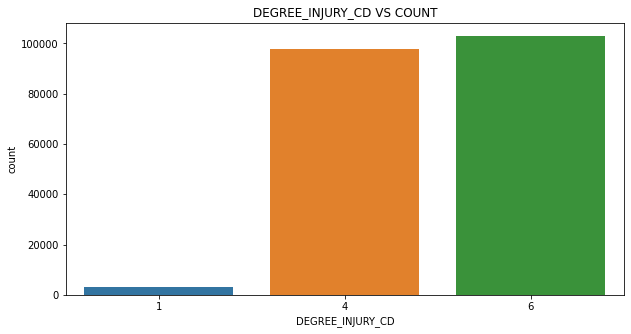

In [72]:
#there is imbalance presence in the target variable
#we need to do oversampling for the analysis
plt.figure(figsize=(10,5))
plt.title('DEGREE_INJURY_CD VS COUNT')
sns.countplot(data=DF_2, x ='DEGREE_INJURY_CD');

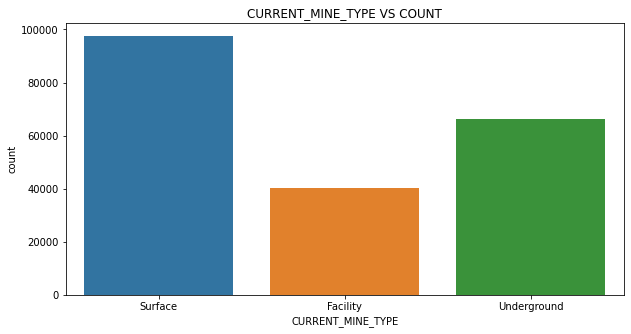

In [73]:
#check the count of the mine 
plt.figure(figsize=(10,5))
plt.title('CURRENT_MINE_TYPE VS COUNT')
sns.countplot(data=DF_2, x ='CURRENT_MINE_TYPE');

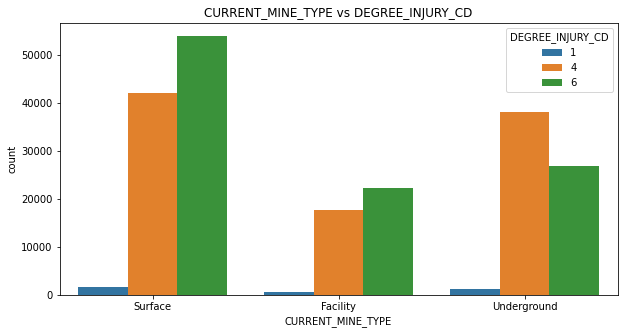

In [74]:
#current minetype count with degree of injury
plt.figure(figsize=(10,5))
plt.title('CURRENT_MINE_TYPE vs DEGREE_INJURY_CD')
sns.countplot(data=DF_2, x ='CURRENT_MINE_TYPE', hue='DEGREE_INJURY_CD');

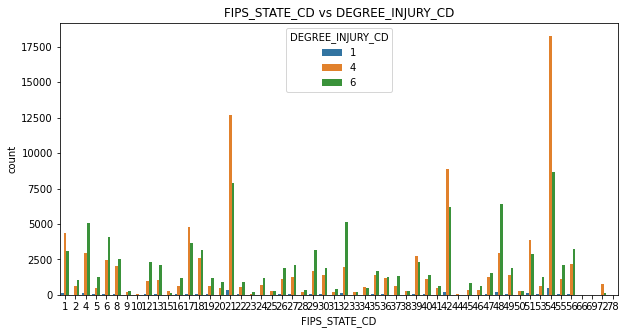

In [75]:

#get only top 10 states high rate results

#total experice vs degree of injury
plt.figure(figsize=(10,5))
plt.title('FIPS_STATE_CD vs DEGREE_INJURY_CD')
sns.countplot(data=DF_2, x ='FIPS_STATE_CD', hue='DEGREE_INJURY_CD');

In [76]:
DF_2.DEGREE_INJURY_CD.value_counts()

6    102951
4     97874
1      3286
Name: DEGREE_INJURY_CD, dtype: int64

In [77]:
#duplicating the dataset for the fuether analysis
DF_3 = DF_2.copy()

#ENCODING

In [78]:
#encoding few of the columns
#once the VIZ is done for the modeling it is necessary to change the qualitative 
#variable to quantative variable for the analysis

def Encoding(D_frame, columns):

    D_frame = D_frame.replace(columns)
    D_frame.head() 

    return D_frame

In [79]:
#we replace all the qualitative data with the numeric value
clean_data   = {"TRANS_TERM":           {"Y": 1, "N": 0},
                "COAL_METAL_IND":       {"M": 0, "C": 1},
                "CURRENT_MINE_TYPE":    {"Surface": 1, "Facility": 2,"Underground":3 },               
                "CURRENT_MINE_STATUS":  {'Abandoned':1,'Abandoned and Sealed': 2,"Active": 3,'Intermittent':4,'New Mine':5, "NonProducing": 6,'Temporarily Idled':7}}
      
DF_3 = Encoding( DF_3, clean_data)

In [80]:
#function call for encoding 
def Encoding(D_frame_1, columns):

    D_frame_1 = D_frame_1.replace(columns)
    D_frame_1.head() 

    return D_frame_1

In [81]:
#we replace all the qualitative data with the numeric value
data   = {"tot_expr_01":           { '0-1':1,'1-3':2,'3-6':3,'6-10':4,'10-20':5,'20-30':6,'30+':7 },
                "MINE_EXPER_01":       {'0-1':1,'1-3':2,'3-6':3,'6-10':4,'10-20':5,'20-30':6,'30+':7},
                "JOB_EXPER_01":    {'0-1':1,'1-3':2,'3-6':3,'6-10':4,'10-20':5,'20-30':6,'30+':7 },               
                }
      
DF_3 = Encoding( DF_3, data)

In [82]:
#conversion of datatype
DF_3['ACCIDENT_DT']= pd.to_datetime(DF_3['ACCIDENT_DT'])

In [83]:
#check for the null values
#we can change the data type after handling the dtype

#Handling the missing values

In [84]:
DF_3.isnull().sum()

MINE_ID                    0
SUBUNIT_CD                 0
ACCIDENT_DT                0
CAL_YR                     0
CAL_QTR                    0
FISCAL_YR                  0
FISCAL_QTR                 0
DEGREE_INJURY_CD           0
FIPS_STATE_CD              0
SHIFT_BEGIN_TIME           0
CLASSIFICATION_CD        851
ACCIDENT_TYPE_CD         852
NO_INJURIES                0
OCCUPATION_CD            491
ACTIVITY_CD              866
INJURY_SOURCE_CD         877
NATURE_INJURY_CD         893
INJ_BODY_PART_CD         893
DAYS_LOST              27628
TRANS_TERM              3125
COAL_METAL_IND            18
CLASSIFICATION             0
ACCIDENT_TYPE              0
NATURE_INJURY              0
INJ_BODY_PART              0
CURRENT_MINE_TYPE          0
CURRENT_MINE_STATUS        0
PRIMARY_CANVASS_CD         5
LONGITUDE               6995
LATITUDE                6995
ACCIDENT_TIME              0
tot_expr_01                0
MINE_EXPER_01              0
JOB_EXPER_01               0
dtype: int64

In [85]:
#installing the req library
#check for the missing variables

import missingno as msno

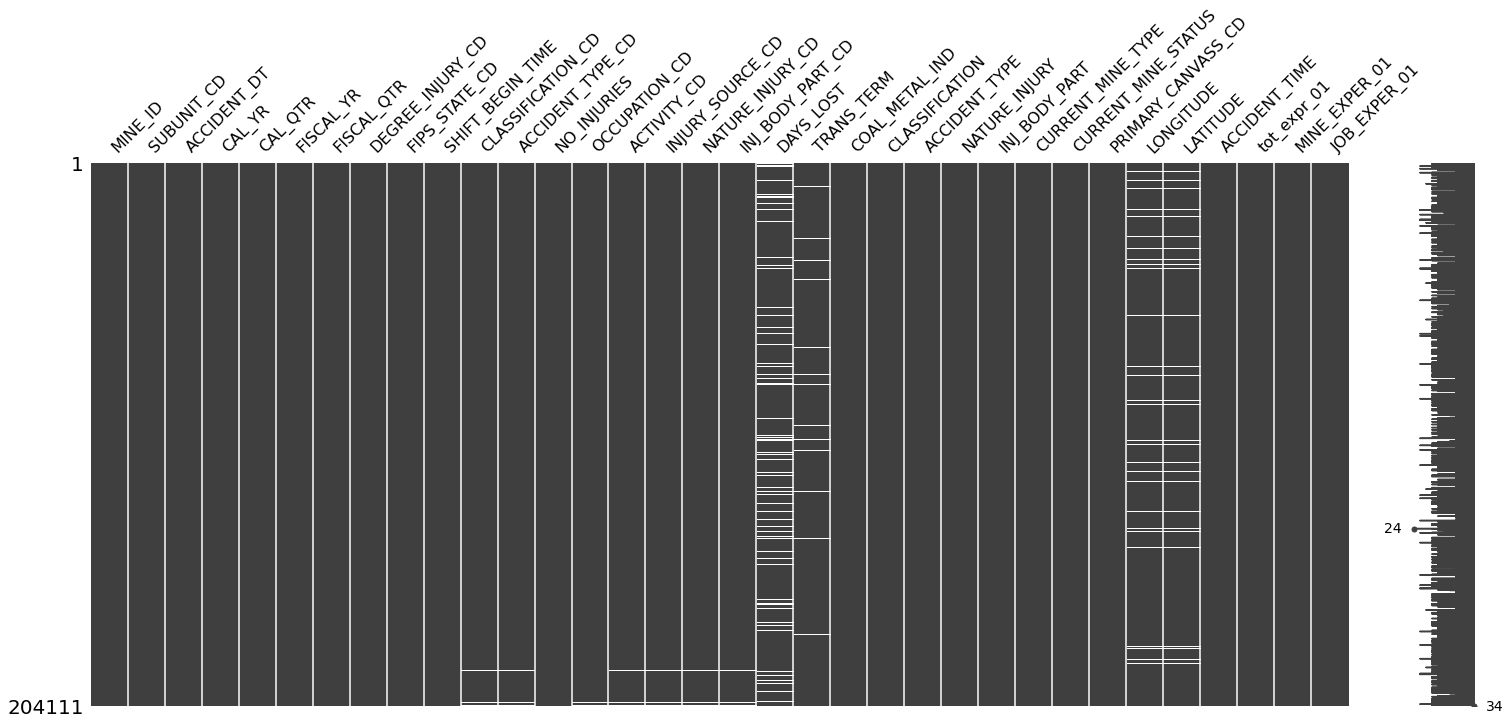

In [86]:
#missng value distribution at random
msno.matrix(DF_3)

 with the viz we can say that 'CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD','OCCUPATION_CD', 'ACTIVITY_CD',
'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD', has continious missing values forward or backward missing value fill
does not work, since these columns has very less values around 800 the values are very less compared to the whole data
so these are dropped
    
'COAL_METAL_IND','PRIMARY_CANVASS_CD' has less num of missing values it can be dropped

In [87]:
#duplicating for further analysis
DF_miss = DF_3.copy()

In [88]:
DF_miss.shape

(204111, 34)

In [89]:
#dropping the missing rows as explained above
DF_miss = DF_miss.dropna(subset=['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD','OCCUPATION_CD', 'ACTIVITY_CD',
       'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD','COAL_METAL_IND','PRIMARY_CANVASS_CD'])

In [90]:
DF_miss.isnull().sum()

MINE_ID                    0
SUBUNIT_CD                 0
ACCIDENT_DT                0
CAL_YR                     0
CAL_QTR                    0
FISCAL_YR                  0
FISCAL_QTR                 0
DEGREE_INJURY_CD           0
FIPS_STATE_CD              0
SHIFT_BEGIN_TIME           0
CLASSIFICATION_CD          0
ACCIDENT_TYPE_CD           0
NO_INJURIES                0
OCCUPATION_CD              0
ACTIVITY_CD                0
INJURY_SOURCE_CD           0
NATURE_INJURY_CD           0
INJ_BODY_PART_CD           0
DAYS_LOST              27619
TRANS_TERM              3120
COAL_METAL_IND             0
CLASSIFICATION             0
ACCIDENT_TYPE              0
NATURE_INJURY              0
INJ_BODY_PART              0
CURRENT_MINE_TYPE          0
CURRENT_MINE_STATUS        0
PRIMARY_CANVASS_CD         0
LONGITUDE               6940
LATITUDE                6940
ACCIDENT_TIME              0
tot_expr_01                0
MINE_EXPER_01              0
JOB_EXPER_01               0
dtype: int64

In [91]:
#DF_miss.DAYS_LOST.head(20)

**Daylost mainly correlate with the degree of injury it better to use multi columns that help to find the missing value and impute using KNN**

In [92]:
from sklearn.impute import KNNImputer

In [93]:
knnimputer = KNNImputer(n_neighbors = 2)

In [94]:
impute = DF_miss[['DEGREE_INJURY_CD',
       'SHIFT_BEGIN_TIME', 'CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD',
       'NO_INJURIES', 'OCCUPATION_CD', 'ACTIVITY_CD', 'INJURY_SOURCE_CD',
       'NATURE_INJURY_CD', 'DAYS_LOST',
       'tot_expr_01', 'MINE_EXPER_01', 'JOB_EXPER_01','TRANS_TERM']]

In [95]:
impute.iloc[:,:] = knnimputer.fit_transform(impute)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [96]:
DF_miss.drop(columns=['TRANS_TERM','DAYS_LOST'], axis=1,inplace=True)

In [97]:
DF_miss=pd.concat([DF_miss, impute[['DAYS_LOST','TRANS_TERM']]], axis=1)
DF_miss

,MINE_ID,SUBUNIT_CD,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,FIPS_STATE_CD,SHIFT_BEGIN_TIME,...,CURRENT_MINE_STATUS,PRIMARY_CANVASS_CD,LONGITUDE,LATITUDE,ACCIDENT_TIME,tot_expr_01,MINE_EXPER_01,JOB_EXPER_01,DAYS_LOST,TRANS_TERM
0,100003,3,2013-08-12,2013,3,2013,4,6,1,700,...,3,6.0,-85.753333,38.256389,2300,2,2,2,0.0,0.0
1,100009,3,2005-11-13,2005,4,2006,1,6,1,700,...,3,6.0,-86.763333,33.586388,700,7,7,7,0.0,0.0
2,100011,30,2006-07-14,2006,3,2006,4,6,1,700,...,3,6.0,-86.333056,33.240278,700,6,6,4,0.0,0.0
3,100011,30,2009-01-08,2009,1,2009,2,6,1,700,...,3,6.0,-86.333056,33.240278,1500,6,6,6,0.0,0.0
4,100011,30,2010-01-14,2010,1,2010,2,4,1,700,...,3,6.0,-86.333056,33.240278,700,7,7,1,366.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204106,5400311,30,2006-03-21,2006,1,2006,2,4,72,700,...,1,6.0,-66.136388,18.334444,700,1,1,1,51.0,0.0
204107,5400319,3,2007-08-14,2007,3,2007,4,4,72,700,...,1,6.0,-67.04,18.098055,700,7,1,6,17.0,0.0
204108,5400428,3,2006-11-03,2006,4,2007,1,4,72,700,...,3,6.0,-65.876667,18.049444,700,7,7,2,7.0,0.0
204109,5400443,3,2007-05-28,2007,2,2007,3,4,72,700,...,1,6.0,-66.057778,18.449722,700,1,1,1,127.0,0.0


In [98]:
DF_miss.isnull().sum()

MINE_ID                   0
SUBUNIT_CD                0
ACCIDENT_DT               0
CAL_YR                    0
CAL_QTR                   0
FISCAL_YR                 0
FISCAL_QTR                0
DEGREE_INJURY_CD          0
FIPS_STATE_CD             0
SHIFT_BEGIN_TIME          0
CLASSIFICATION_CD         0
ACCIDENT_TYPE_CD          0
NO_INJURIES               0
OCCUPATION_CD             0
ACTIVITY_CD               0
INJURY_SOURCE_CD          0
NATURE_INJURY_CD          0
INJ_BODY_PART_CD          0
COAL_METAL_IND            0
CLASSIFICATION            0
ACCIDENT_TYPE             0
NATURE_INJURY             0
INJ_BODY_PART             0
CURRENT_MINE_TYPE         0
CURRENT_MINE_STATUS       0
PRIMARY_CANVASS_CD        0
LONGITUDE              6940
LATITUDE               6940
ACCIDENT_TIME             0
tot_expr_01               0
MINE_EXPER_01             0
JOB_EXPER_01              0
DAYS_LOST                 0
TRANS_TERM                0
dtype: int64

In [99]:
#filling the null values with the zero
#need to work on imputing the missing values
# long and lat value with zrero
DF_3 = DF_miss.fillna(0)

In [100]:
#count analysis and checking the presence of categories counts in each cat columns

In [101]:
DF_4 = DF_3.copy()

In [102]:
#from the correlation graph it can be seen that cal year and f year has more correlation one needs to be removed for further 
#analysis

In [103]:
#conver the dtype of the main data frame
#to convert it to dummy converting the datatype
DF_4[['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD',
       'ACTIVITY_CD', 'INJURY_SOURCE_CD', 'NATURE_INJURY_CD',
       'INJ_BODY_PART_CD', 'DAYS_LOST', 'TRANS_TERM', 'COAL_METAL_IND','PRIMARY_CANVASS_CD']] = DF_4[['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD',
       'ACTIVITY_CD', 'INJURY_SOURCE_CD', 'NATURE_INJURY_CD',
       'INJ_BODY_PART_CD', 'DAYS_LOST', 'TRANS_TERM', 'COAL_METAL_IND','PRIMARY_CANVASS_CD']].astype(int)

In [104]:
DF_5 = DF_4.copy()

In [105]:
#dropping time stamp and long and lat as it wont make any sense for the further analysis

DF_5.drop(columns=['FIPS_STATE_CD','MINE_ID','ACCIDENT_DT','SUBUNIT_CD', 'LONGITUDE','LATITUDE'], axis=1,inplace=True)

In [106]:
DF_5.columns

Index(['CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'DEGREE_INJURY_CD',
       'SHIFT_BEGIN_TIME', 'CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD',
       'NO_INJURIES', 'OCCUPATION_CD', 'ACTIVITY_CD', 'INJURY_SOURCE_CD',
       'NATURE_INJURY_CD', 'INJ_BODY_PART_CD', 'COAL_METAL_IND',
       'CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY', 'INJ_BODY_PART',
       'CURRENT_MINE_TYPE', 'CURRENT_MINE_STATUS', 'PRIMARY_CANVASS_CD',
       'ACCIDENT_TIME', 'tot_expr_01', 'MINE_EXPER_01', 'JOB_EXPER_01',
       'DAYS_LOST', 'TRANS_TERM'],
      dtype='object')

# Univariate Outlier Analysis (on numerical columns)

In [107]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
DF_5.describe(percentiles=[.25, .5, .75, .90, .95, .99])


,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,SHIFT_BEGIN_TIME,CLASSIFICATION_CD,ACCIDENT_TYPE_CD,NO_INJURIES,OCCUPATION_CD,...,COAL_METAL_IND,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,PRIMARY_CANVASS_CD,ACCIDENT_TIME,tot_expr_01,MINE_EXPER_01,JOB_EXPER_01,DAYS_LOST,TRANS_TERM
count,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,...,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000,203178.000000
mean,2008.709432,2.458672,2008.929077,2.580092,4.963170,1079.147349,12.572621,16.173621,1.021597,257.627612,...,0.431085,1.845963,2.941982,4.535535,1303.112542,3.936519,3.010882,3.165544,28.124915,0.045261
std,6.290575,1.090855,6.298735,1.106355,1.113946,578.149281,4.433578,11.136319,0.517391,144.901568,...,0.495229,0.882340,1.426429,2.347205,637.782002,1.982842,1.884077,1.850920,61.838183,0.207876
min,2000.000000,1.000000,2000.000000,1.000000,1.000000,700.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,700.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2003.000000,1.000000,2004.000000,2.000000,4.000000,700.000000,9.000000,5.000000,1.000000,109.000000,...,0.000000,1.000000,2.000000,2.000000,700.000000,2.000000,1.000000,2.000000,0.000000,0.000000
50%,2008.000000,2.000000,2008.000000,3.000000,6.000000,700.000000,10.000000,17.000000,1.000000,304.000000,...,0.000000,2.000000,3.000000,5.000000,1500.000000,4.000000,3.000000,3.000000,1.000000,0.000000
75%,2013.000000,3.000000,2014.000000,4.000000,6.000000,1500.000000,18.000000,27.000000,1.000000,370.000000,...,1.000000,3.000000,3.000000,6.000000,1500.000000,6.000000,4.000000,5.000000,26.000000,0.000000
90%,2018.000000,4.000000,2019.000000,4.000000,6.000000,2300.000000,18.000000,30.000000,1.000000,382.000000,...,1.000000,3.000000,6.000000,8.000000,2300.000000,7.000000,6.000000,6.000000,90.000000,0.000000
95%,2020.000000,4.000000,2020.000000,4.000000,6.000000,2300.000000,19.000000,30.000000,1.000000,449.000000,...,1.000000,3.000000,6.000000,8.000000,2300.000000,7.000000,7.000000,7.000000,155.000000,0.000000
99%,2022.000000,4.000000,2022.000000,4.000000,6.000000,2300.000000,21.000000,38.000000,1.000000,640.000000,...,1.000000,3.000000,7.000000,8.000000,2300.000000,7.000000,7.000000,7.000000,298.000000,1.000000


from the desc it can be seen that max to 99% if there are any big diff that will be considered as outliers and will be removed 
for the further analysis only these columns are considered and removed accordingly by seeing the box plot by keeping eye on the
data loss


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


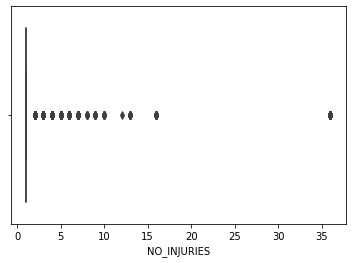

In [108]:


# Analysing the column 'NO_INJURIES' to check the outliers:
sns.boxplot(DF_5['NO_INJURIES'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


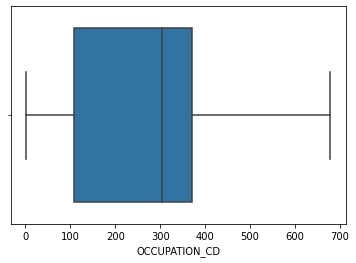

In [109]:
# Analysing the column 'OCCUPATION_CD' to check the outliers:
sns.boxplot(DF_5['OCCUPATION_CD'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


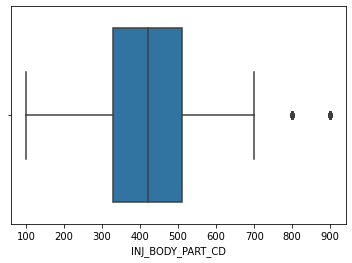

In [110]:
# Analysing the column 'INJ_BODY_PART_CD' to check the outliers:
sns.boxplot(DF_5['INJ_BODY_PART_CD'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


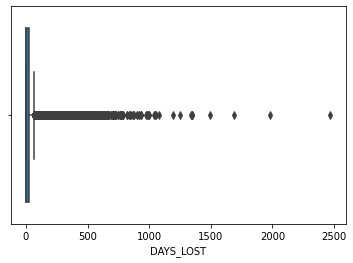

In [111]:
# Analysing the column 'DAYS_LOST' to check the outliers:
sns.boxplot(DF_5['DAYS_LOST'])
plt.show()

In [112]:
#listing all at once

list_features = ['CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR',
       'ACCIDENT_TIME', 'DEGREE_INJURY_CD',
       'SHIFT_BEGIN_TIME', 'CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD',
       'NO_INJURIES', 'OCCUPATION_CD', 'ACTIVITY_CD', 'INJURY_SOURCE_CD',
       'NATURE_INJURY_CD', 'INJ_BODY_PART_CD', 'DAYS_LOST', 'TRANS_TERM',
       'COAL_METAL_IND', 'CURRENT_MINE_TYPE', 'CURRENT_MINE_STATUS',
       'PRIMARY_CANVASS_CD', 'tot_expr_01', 'MINE_EXPER_01', 'JOB_EXPER_01']

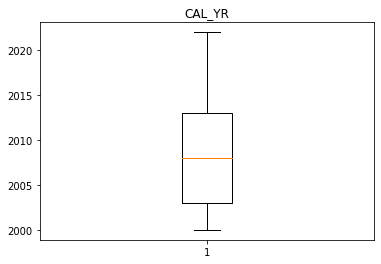

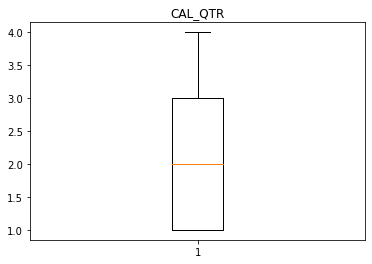

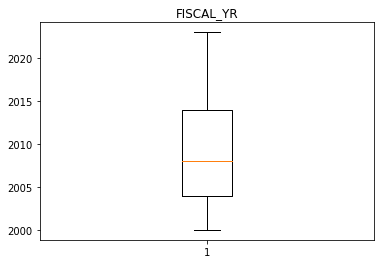

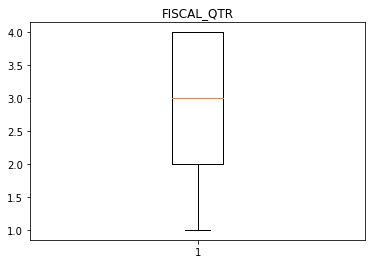

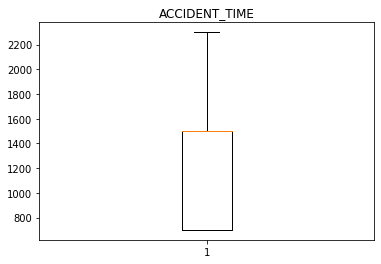

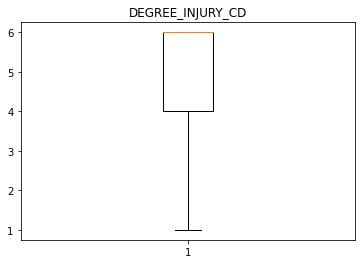

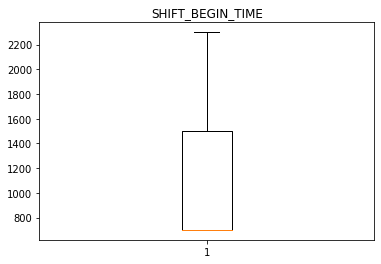

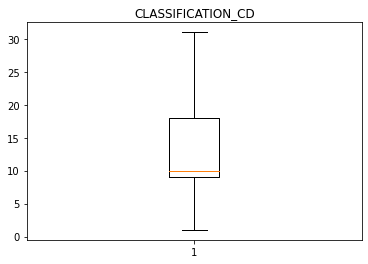

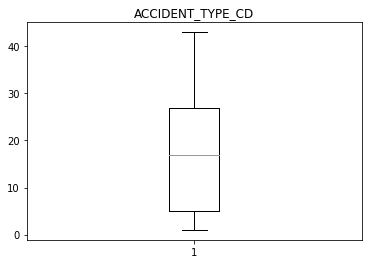

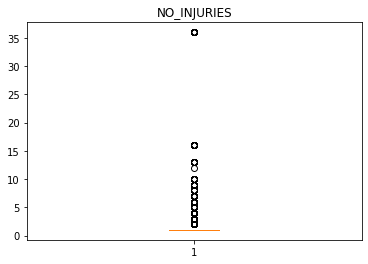

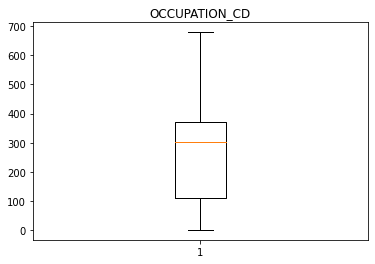

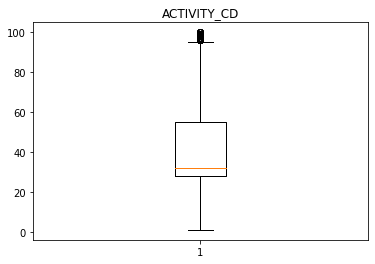

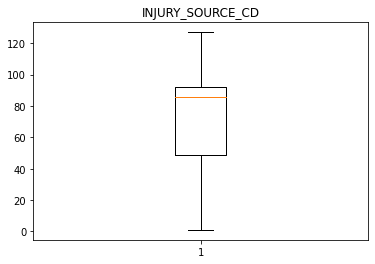

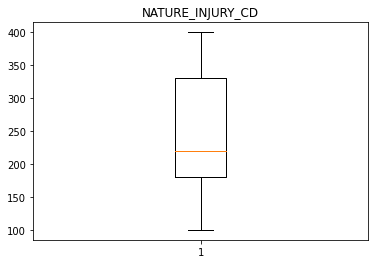

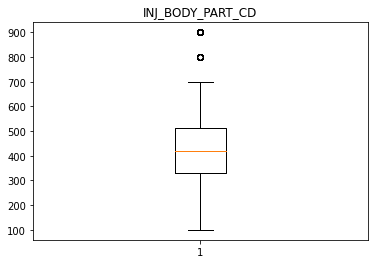

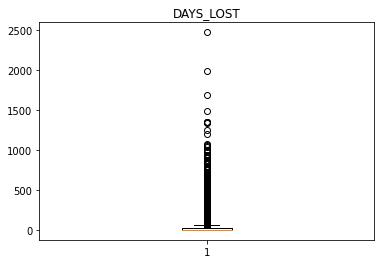

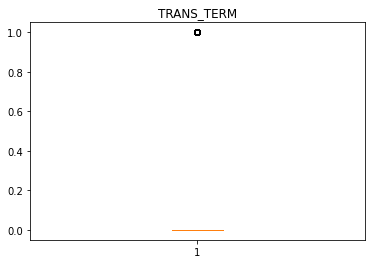

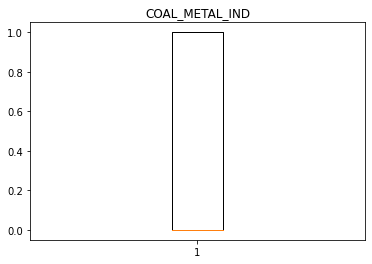

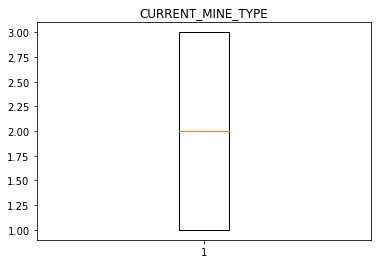

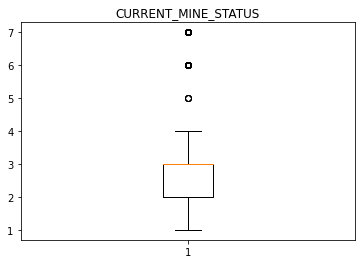

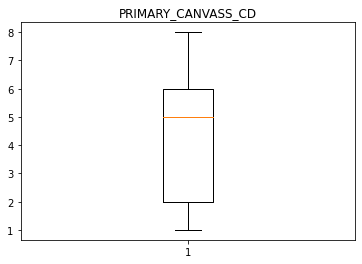

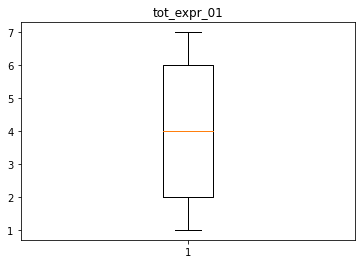

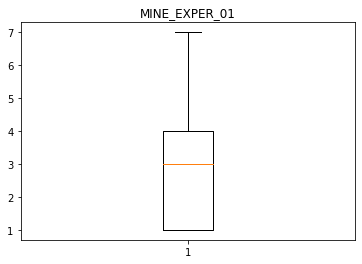

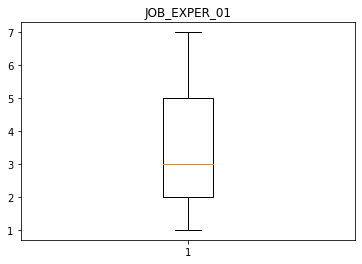

In [113]:
#more skewness and outliers found in the dataset
#Box plot to check skewness and outliers
#all at once
for feature in list_features:
    plt.boxplot(DF_5[feature])
    plt.title(feature)
    plt.show()

In [114]:
#remove outliers which ever the outliers present outside the zone along keeping the eyes on the nums of row loss following 
#removal of rows performed

DF_6 = DF_5.copy()

In [115]:
#remove outliers above 15 values removed
DF_6=DF_6[~(DF_6["NO_INJURIES"]>15)]

In [116]:
#remove outliers above 750 values removed
DF_6=DF_6[~(DF_6["INJ_BODY_PART_CD"]>=750)]

In [117]:
#remove outliers above 1100 values removed
DF_6=DF_6[~(DF_6["DAYS_LOST"]>=1100)]

In [118]:
#mine 5,6 and 7 defines newmines, non producing and temp idle which will have no significane for the problem statements are removed
DF_6=DF_6[~(DF_6["CURRENT_MINE_STATUS"]>=5)]

In [119]:
#remove trans as it has high imbalance

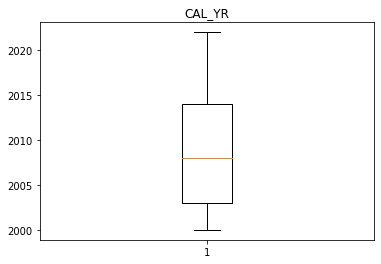

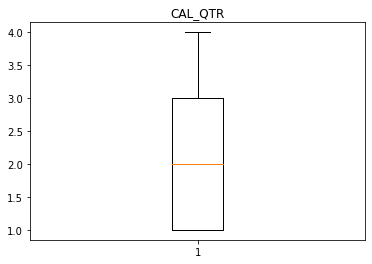

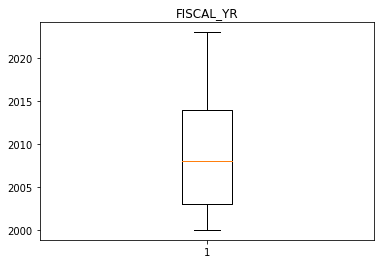

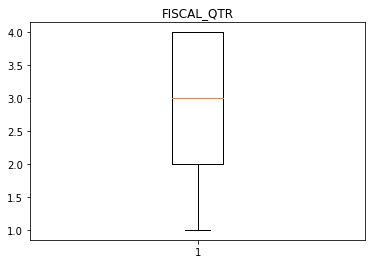

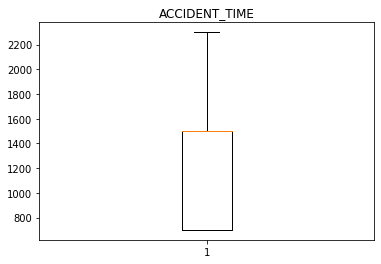

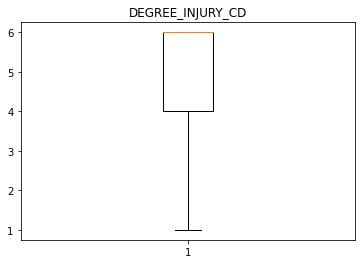

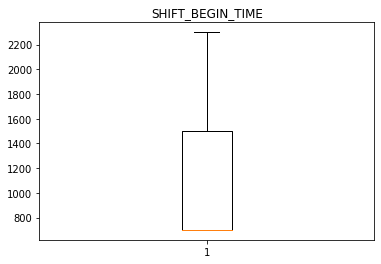

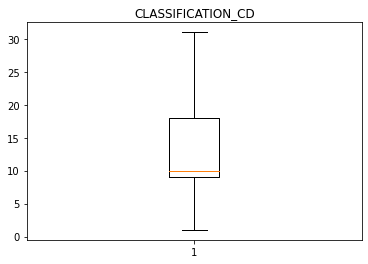

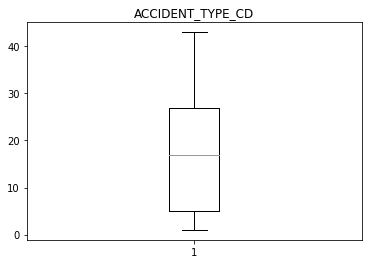

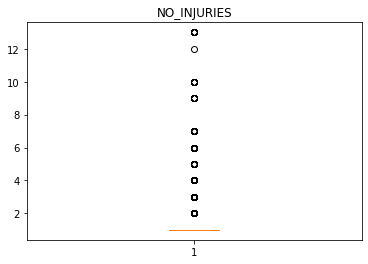

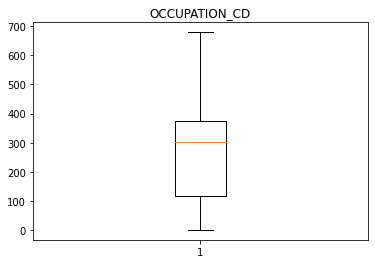

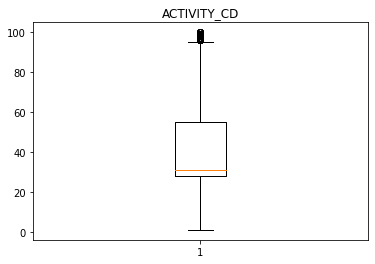

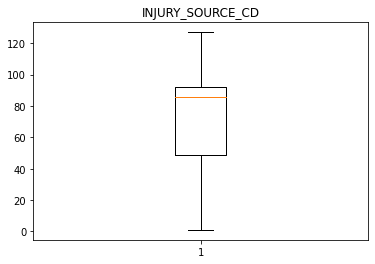

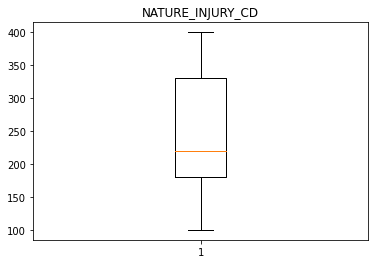

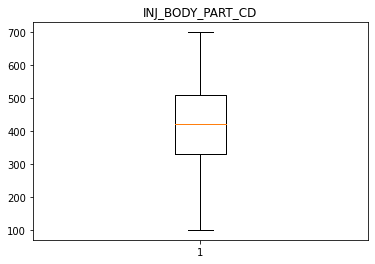

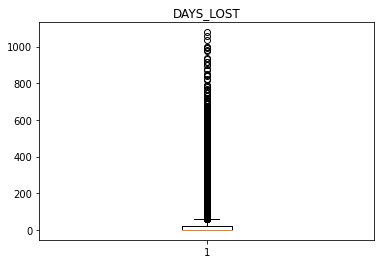

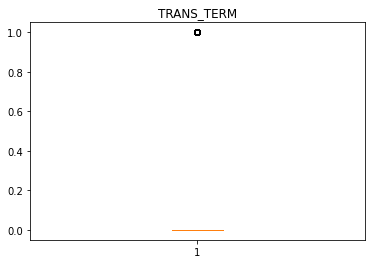

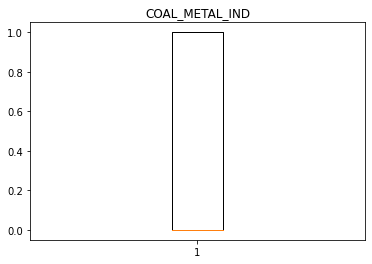

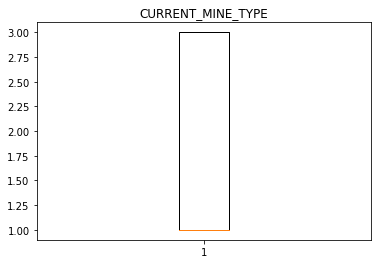

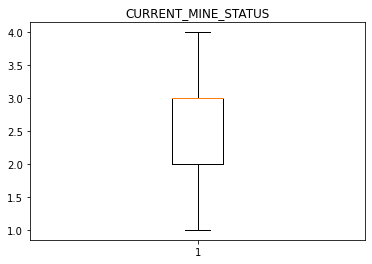

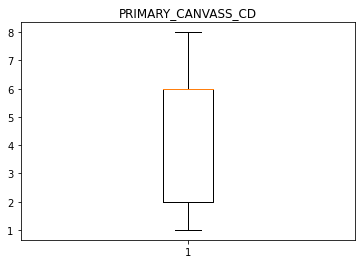

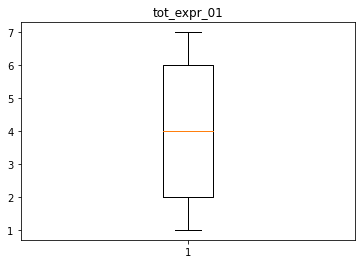

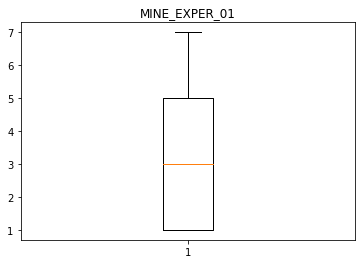

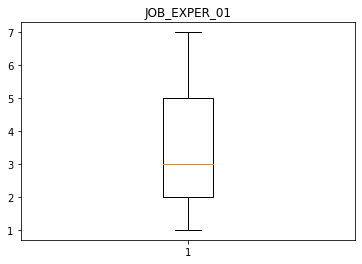

In [120]:
#aftermath of removal of the outliers 
for feature in list_features:
    plt.boxplot(DF_6[feature])
    plt.title(feature)
    plt.show()

In [121]:
DF_10 = DF_6.copy()

In [122]:
#reset the index as num of rows will be removed and to make it proper
DF_10 = DF_10.reset_index()
DF_10

,index,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,SHIFT_BEGIN_TIME,CLASSIFICATION_CD,ACCIDENT_TYPE_CD,NO_INJURIES,...,INJ_BODY_PART,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,PRIMARY_CANVASS_CD,ACCIDENT_TIME,tot_expr_01,MINE_EXPER_01,JOB_EXPER_01,DAYS_LOST,TRANS_TERM
0,0,2013,3,2013,4,6,700,18,12,1,...,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),1,3,6,2300,2,2,2,0,0
1,1,2005,4,2006,1,6,700,9,24,1,...,FINGER(S)/THUMB,1,3,6,700,7,7,7,0,0
2,2,2006,3,2006,4,6,700,10,18,1,...,JAW INCLUDE CHIN,1,3,6,700,6,6,4,0,0
3,3,2009,1,2009,2,6,700,18,17,1,...,KNEE/PATELLA,1,3,6,1500,6,6,6,0,0
4,4,2010,1,2010,2,4,700,18,17,1,...,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),1,3,6,700,7,7,1,366,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181346,204106,2006,1,2006,2,4,700,10,4,2,...,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,1,1,6,700,1,1,1,51,0
181347,204107,2007,3,2007,4,4,700,9,21,1,...,"UPPER EXTREMITIES, MULTIPLE",1,1,6,700,7,1,6,17,0
181348,204108,2006,4,2007,1,4,700,17,8,1,...,EYE(S) OPTIC NERVE/VISON,1,3,6,700,7,7,2,7,0
181349,204109,2007,2,2007,3,4,700,12,24,1,...,FINGER(S)/THUMB,1,1,6,700,1,1,1,127,0


In [123]:
DF_10 = DF_10.drop(['index'], axis = 1)

In [124]:
DF_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181351 entries, 0 to 181350
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   CAL_YR               181351 non-null  int32 
 1   CAL_QTR              181351 non-null  int32 
 2   FISCAL_YR            181351 non-null  int32 
 3   FISCAL_QTR           181351 non-null  int32 
 4   DEGREE_INJURY_CD     181351 non-null  int32 
 5   SHIFT_BEGIN_TIME     181351 non-null  int32 
 6   CLASSIFICATION_CD    181351 non-null  int64 
 7   ACCIDENT_TYPE_CD     181351 non-null  int64 
 8   NO_INJURIES          181351 non-null  int32 
 9   OCCUPATION_CD        181351 non-null  int64 
 10  ACTIVITY_CD          181351 non-null  int64 
 11  INJURY_SOURCE_CD     181351 non-null  int64 
 12  NATURE_INJURY_CD     181351 non-null  int64 
 13  INJ_BODY_PART_CD     181351 non-null  int64 
 14  COAL_METAL_IND       181351 non-null  int64 
 15  CLASSIFICATION       181351 non-nu

now that we have many category columns, listing and seperating the multicategory column, less category column and a continious column


lets start converting it to one hot encoding 
few of column which has more num of categories are encoeded for first 10 frequent columns 

cat_col = ['CAL_QTR', 'FISCAL_QTR', 'SHIFT_BEGIN_TIME', 'ACCIDENT_TIME', 'TRANS_TERM', 'COAL_METAL_IND', 
'CURRENT_MINE_TYPE', 'CURRENT_MINE_STATUS', 'PRIMARY_CANVASS_CD','tot_expr_01','MINE_EXPER_01', 'JOB_EXPER_01']



multiple_cat_col = ['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD', 'ACTIVITY_CD', 
                'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD']
                
                
continuous = ['CAL_YR', 'FISCAL_YR', 'NO_INJURIES', 'DAYS_LOST']

In [125]:
multiple_cat_col = DF_10[['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD', 'ACTIVITY_CD', 
                'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD','CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY',
                      'INJ_BODY_PART']]

In [126]:
multiple_cat_col[['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD', 'ACTIVITY_CD', 
                'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD','CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY',
                      'INJ_BODY_PART']].astype('category').describe()

,CLASSIFICATION_CD,ACCIDENT_TYPE_CD,OCCUPATION_CD,ACTIVITY_CD,INJURY_SOURCE_CD,NATURE_INJURY_CD,INJ_BODY_PART_CD,CLASSIFICATION,ACCIDENT_TYPE,NATURE_INJURY,INJ_BODY_PART
count,181351,181351,181351,181351,181351,181351,181351,181351,181351,181351,181351
unique,22,43,247,99,127,32,44,22,43,32,44
top,9,8,304,28,88,330,340,HANDLING OF MATERIALS,Struck by... NEC,"SPRAIN,STRAIN RUPT DISC",FINGER(S)/THUMB
freq,63302,26035,29874,35591,23669,60424,32144,63302,26035,60424,32144


OCCUPATION_CD has 251 unique values which tells the job of the labous which can be dropped as it has many random defination
like wise activity, injury source also
these three columns will be dropped for further analysis and proper explaination will be provided


# Encoding the  multiple category column
reference: http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf
by considering only top 10 frequently occuring variables for the column CLASSIFICATION_CD, ACCIDENT_TYPE_CD, NATURE_INJURY_CD adn INJ_BODY_PART_CD,(encoding columns are neglected only the description columns of these are considered)

In [127]:
#top 10 will be considered
multiple_cat_col['CLASSIFICATION'].value_counts().sort_values(ascending=False).head(10)

HANDLING OF MATERIALS                    63302
SLIP OR FALL OF PERSON                   36587
HANDTOOLS (NONPOWERED)                   23545
MACHINERY                                22244
POWERED HAULAGE                          15399
FALL OF ROOF OR BACK                      5301
OTHER                                     4535
STEPPING OR KNEELING ON OBJECT            2965
STRIKING OR BUMPING                       1906
FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL     1517
Name: CLASSIFICATION, dtype: int64

In [128]:
#list of most freq categories
top_10 = [x for x in multiple_cat_col['CLASSIFICATION'].value_counts().sort_values(ascending=False).head(10).index]

top_10

['HANDLING OF MATERIALS',
 'SLIP OR FALL OF PERSON',
 'HANDTOOLS (NONPOWERED)',
 'MACHINERY',
 'POWERED HAULAGE',
 'FALL OF ROOF OR BACK',
 'OTHER',
 'STEPPING OR KNEELING ON OBJECT',
 'STRIKING OR BUMPING',
 'FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL']

In [129]:
import numpy as np

In [130]:
#add top 10 freq bin variables

for label in top_10:
    multiple_cat_col[label] = np.where(multiple_cat_col['CLASSIFICATION'] == label, 1,0)
    
multiple_cat_col[['CLASSIFICATION']+top_10].head(5)

<ipython-input-130-4f5deec38ab0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_cat_col[label] = np.where(multiple_cat_col['CLASSIFICATION'] == label, 1,0)


,CLASSIFICATION,HANDLING OF MATERIALS,SLIP OR FALL OF PERSON,HANDTOOLS (NONPOWERED),MACHINERY,POWERED HAULAGE,FALL OF ROOF OR BACK,OTHER,STEPPING OR KNEELING ON OBJECT,STRIKING OR BUMPING,FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL
0,SLIP OR FALL OF PERSON,0,1,0,0,0,0,0,0,0,0
1,HANDLING OF MATERIALS,1,0,0,0,0,0,0,0,0,0
2,HANDTOOLS (NONPOWERED),0,0,1,0,0,0,0,0,0,0
3,SLIP OR FALL OF PERSON,0,1,0,0,0,0,0,0,0,0
4,SLIP OR FALL OF PERSON,0,1,0,0,0,0,0,0,0,0


In [131]:
#list of most freq categories
top_10_1 = [x for x in multiple_cat_col['ACCIDENT_TYPE'].value_counts().sort_values(ascending=False).head(10).index]

top_10_1

['Struck by... NEC',
 'Over-exertion NEC',
 'Struck by falling object',
 'Over-exertion in lifting objects',
 'Caught in, under or between a moving and a stationary object',
 'Struck against stationary object',
 'Fall to the walkway or working surface',
 'Struck against a moving object',
 'Struck by flying object',
 'Caught in, under or between NEC']

In [132]:
#10 binary variables

for label in top_10_1:
    multiple_cat_col[label] = np.where(multiple_cat_col['ACCIDENT_TYPE'] == label, 1,0)
    
multiple_cat_col[['ACCIDENT_TYPE']+top_10_1].head(10)

<ipython-input-132-12c81e898a04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_cat_col[label] = np.where(multiple_cat_col['ACCIDENT_TYPE'] == label, 1,0)


,ACCIDENT_TYPE,Struck by... NEC,Over-exertion NEC,Struck by falling object,Over-exertion in lifting objects,"Caught in, under or between a moving and a stationary object",Struck against stationary object,Fall to the walkway or working surface,Struck against a moving object,Struck by flying object,"Caught in, under or between NEC"
0,Fall from machine,0,0,0,0,0,0,0,0,0,0
1,"Caught in, under or between NEC",0,0,0,0,0,0,0,0,0,1
2,Fall onto or against objects,0,0,0,0,0,0,0,0,0,0
3,Fall to the walkway or working surface,0,0,0,0,0,0,1,0,0,0
4,Fall to the walkway or working surface,0,0,0,0,0,0,1,0,0,0
5,Struck by flying object,0,0,0,0,0,0,0,0,1,0
6,Over-exertion NEC,0,1,0,0,0,0,0,0,0,0
7,Fall onto or against objects,0,0,0,0,0,0,0,0,0,0
8,Over-exertion NEC,0,1,0,0,0,0,0,0,0,0
9,Struck by... NEC,1,0,0,0,0,0,0,0,0,0


In [133]:
#list of most freq categories
top_10_2 = [x for x in multiple_cat_col['NATURE_INJURY'].value_counts().sort_values(ascending=False).head(10).index]

top_10_2

['SPRAIN,STRAIN RUPT DISC',
 'CUT,LACER,PUNCT-OPN WOUND',
 'FRACTURE,CHIP',
 'CONTUSN,BRUISE,INTAC SKIN',
 'UNCLASSIFIED,NOT DETERMED',
 'MULTIPLE INJURIES',
 'CRUSHING',
 'BURN OR SCALD (HEAT)',
 'BURN,CHEMICL-FUME,COMPOUN',
 'DUST IN EYES']

In [134]:
#10 binary variables

for label in top_10_2:
    multiple_cat_col[label] = np.where(multiple_cat_col['NATURE_INJURY'] == label, 1,0)
    
multiple_cat_col[['NATURE_INJURY']+top_10_2].head(10)

,NATURE_INJURY,"SPRAIN,STRAIN RUPT DISC","CUT,LACER,PUNCT-OPN WOUND","FRACTURE,CHIP","CONTUSN,BRUISE,INTAC SKIN","UNCLASSIFIED,NOT DETERMED",MULTIPLE INJURIES,CRUSHING,BURN OR SCALD (HEAT),"BURN,CHEMICL-FUME,COMPOUN",DUST IN EYES
0,"SPRAIN,STRAIN RUPT DISC",1,0,0,0,0,0,0,0,0,0
1,"FRACTURE,CHIP",0,0,1,0,0,0,0,0,0,0
2,"CUT,LACER,PUNCT-OPN WOUND",0,1,0,0,0,0,0,0,0,0
3,"CUT,LACER,PUNCT-OPN WOUND",0,1,0,0,0,0,0,0,0,0
4,"SPRAIN,STRAIN RUPT DISC",1,0,0,0,0,0,0,0,0,0
5,"CUT,LACER,PUNCT-OPN WOUND",0,1,0,0,0,0,0,0,0,0
6,"SPRAIN,STRAIN RUPT DISC",1,0,0,0,0,0,0,0,0,0
7,"SPRAIN,STRAIN RUPT DISC",1,0,0,0,0,0,0,0,0,0
8,"SPRAIN,STRAIN RUPT DISC",1,0,0,0,0,0,0,0,0,0
9,AMPUTATION OR ENUCLEATION,0,0,0,0,0,0,0,0,0,0


In [135]:
#list of most freq categories
top_10_3 = [x for x in multiple_cat_col['INJ_BODY_PART'].value_counts().sort_values(ascending=False).head(10).index]

top_10_3

['FINGER(S)/THUMB',
 'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)',
 'KNEE/PATELLA',
 'SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA)',
 'EYE(S) OPTIC NERVE/VISON',
 'HAND (NOT WRIST OR FINGERS)',
 'MULTIPLE PARTS (MORE THAN ONE MAJOR)',
 'ANKLE',
 'FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS',
 'HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)']

In [136]:
#10 binary variables

for label in top_10_3:
    multiple_cat_col[label] = np.where(multiple_cat_col['INJ_BODY_PART'] == label, 1,0)
    
multiple_cat_col[['INJ_BODY_PART']+top_10_3].head(10)

,INJ_BODY_PART,FINGER(S)/THUMB,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),KNEE/PATELLA,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),EYE(S) OPTIC NERVE/VISON,HAND (NOT WRIST OR FINGERS),MULTIPLE PARTS (MORE THAN ONE MAJOR),ANKLE,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)
0,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0,1,0,0,0,0,0,0,0,0
1,FINGER(S)/THUMB,1,0,0,0,0,0,0,0,0,0
2,JAW INCLUDE CHIN,0,0,0,0,0,0,0,0,0,0
3,KNEE/PATELLA,0,0,1,0,0,0,0,0,0,0
4,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),0,0,0,1,0,0,0,0,0,0
5,FINGER(S)/THUMB,1,0,0,0,0,0,0,0,0,0
6,KNEE/PATELLA,0,0,1,0,0,0,0,0,0,0
7,ANKLE,0,0,0,0,0,0,0,1,0,0
8,ANKLE,0,0,0,0,0,0,0,1,0,0
9,FINGER(S)/THUMB,1,0,0,0,0,0,0,0,0,0


In [137]:
#40 new columns are generated from the 4 multi category columns
multiple_cat_col.head()

,CLASSIFICATION_CD,ACCIDENT_TYPE_CD,OCCUPATION_CD,ACTIVITY_CD,INJURY_SOURCE_CD,NATURE_INJURY_CD,INJ_BODY_PART_CD,CLASSIFICATION,ACCIDENT_TYPE,NATURE_INJURY,...,FINGER(S)/THUMB,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),KNEE/PATELLA,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),EYE(S) OPTIC NERVE/VISON,HAND (NOT WRIST OR FINGERS),MULTIPLE PARTS (MORE THAN ONE MAJOR),ANKLE,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)
0,18,12,304,39,117,330,420,SLIP OR FALL OF PERSON,Fall from machine,"SPRAIN,STRAIN RUPT DISC",...,0,1,0,0,0,0,0,0,0,0
1,9,24,304,28,38,220,340,HANDLING OF MATERIALS,"Caught in, under or between NEC","FRACTURE,CHIP",...,1,0,0,0,0,0,0,0,0,0
2,10,18,374,30,88,180,141,HANDTOOLS (NONPOWERED),Fall onto or against objects,"CUT,LACER,PUNCT-OPN WOUND",...,0,0,0,0,0,0,0,0,0,0
3,18,17,304,39,117,180,512,SLIP OR FALL OF PERSON,Fall to the walkway or working surface,"CUT,LACER,PUNCT-OPN WOUND",...,0,0,1,0,0,0,0,0,0,0
4,18,17,374,92,117,330,450,SLIP OR FALL OF PERSON,Fall to the walkway or working surface,"SPRAIN,STRAIN RUPT DISC",...,0,0,0,1,0,0,0,0,0,0


In [138]:
#droping the parent column
multiple_cat_col.drop(columns=['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD', 'ACTIVITY_CD', 
                'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD','CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY',
                      'INJ_BODY_PART'], axis=1,inplace=True)

In [139]:
DF_11 = DF_10.copy()

In [140]:
#droping the same columns in main data frame
DF_11.drop(columns=['CLASSIFICATION_CD', 'ACCIDENT_TYPE_CD', 'OCCUPATION_CD', 'ACTIVITY_CD', 
                'INJURY_SOURCE_CD', 'NATURE_INJURY_CD', 'INJ_BODY_PART_CD','CLASSIFICATION', 'ACCIDENT_TYPE', 'NATURE_INJURY',
                      'INJ_BODY_PART'], axis=1,inplace=True)

In [141]:
#concating both the columns for analysis
DF_11=pd.concat([DF_11, multiple_cat_col], axis=1)
DF_11

,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,DEGREE_INJURY_CD,SHIFT_BEGIN_TIME,NO_INJURIES,COAL_METAL_IND,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,...,FINGER(S)/THUMB,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),KNEE/PATELLA,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),EYE(S) OPTIC NERVE/VISON,HAND (NOT WRIST OR FINGERS),MULTIPLE PARTS (MORE THAN ONE MAJOR),ANKLE,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)
0,2013,3,2013,4,6,700,1,0,1,3,...,0,1,0,0,0,0,0,0,0,0
1,2005,4,2006,1,6,700,1,0,1,3,...,1,0,0,0,0,0,0,0,0,0
2,2006,3,2006,4,6,700,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0
3,2009,1,2009,2,6,700,1,0,1,3,...,0,0,1,0,0,0,0,0,0,0
4,2010,1,2010,2,4,700,1,0,1,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181346,2006,1,2006,2,4,700,2,0,1,1,...,0,0,0,0,0,0,0,0,1,0
181347,2007,3,2007,4,4,700,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
181348,2006,4,2007,1,4,700,1,0,1,3,...,0,0,0,0,1,0,0,0,0,0
181349,2007,2,2007,3,4,700,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [142]:
#other category columns needs to be hot encoded for analysis
categorical_cols = ['CAL_QTR','FISCAL_QTR','SHIFT_BEGIN_TIME','CURRENT_MINE_TYPE','CURRENT_MINE_STATUS','PRIMARY_CANVASS_CD',
                    'tot_expr_01', 'MINE_EXPER_01', 'JOB_EXPER_01', 
                    'ACCIDENT_TIME', 'TRANS_TERM', 'COAL_METAL_IND']



In [143]:
DF_12 = pd.get_dummies(DF_11, columns=categorical_cols,drop_first=True)

In [144]:
DF_12.head()

,CAL_YR,FISCAL_YR,DEGREE_INJURY_CD,NO_INJURIES,DAYS_LOST,HANDLING OF MATERIALS,SLIP OR FALL OF PERSON,HANDTOOLS (NONPOWERED),MACHINERY,POWERED HAULAGE,...,JOB_EXPER_01_2,JOB_EXPER_01_3,JOB_EXPER_01_4,JOB_EXPER_01_5,JOB_EXPER_01_6,JOB_EXPER_01_7,ACCIDENT_TIME_1500,ACCIDENT_TIME_2300,TRANS_TERM_1,COAL_METAL_IND_1
0,2013,2013,6,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,2005,2006,6,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2006,2006,6,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2009,2009,6,1,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,2010,2010,4,1,366,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
DF_13 = DF_12.copy()

# Feature selection using correlation

**A. Checking for constance variance in the column**

In [146]:
#remove the variable has the zero variance 

In [147]:
### It will zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(DF_13)

VarianceThreshold(threshold=0)

In [148]:
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [149]:
DF_13.columns[var_thres.get_support()]

Index(['CAL_YR', 'FISCAL_YR', 'DEGREE_INJURY_CD', 'NO_INJURIES', 'DAYS_LOST',
       'HANDLING OF MATERIALS', 'SLIP OR FALL OF PERSON',
       'HANDTOOLS (NONPOWERED)', 'MACHINERY', 'POWERED HAULAGE',
       'FALL OF ROOF OR BACK', 'OTHER', 'STEPPING OR KNEELING ON OBJECT',
       'STRIKING OR BUMPING', 'FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL',
       'Struck by... NEC', 'Over-exertion NEC', 'Struck by falling object',
       'Over-exertion in lifting objects',
       'Caught in, under or between a moving and a stationary object',
       'Struck against stationary object',
       'Fall to the walkway or working surface',
       'Struck against a moving object', 'Struck by flying object',
       'Caught in, under or between NEC', 'SPRAIN,STRAIN RUPT DISC',
       'CUT,LACER,PUNCT-OPN WOUND', 'FRACTURE,CHIP',
       'CONTUSN,BRUISE,INTAC SKIN', 'UNCLASSIFIED,NOT DETERMED',
       'MULTIPLE INJURIES', 'CRUSHING', 'BURN OR SCALD (HEAT)',
       'BURN,CHEMICL-FUME,COMPOUN', 'DUST IN EYES', '

In [150]:
constant_columns = [column for column in DF_13.columns
                    if column not in DF_13.columns[var_thres.get_support()]]

print(len(constant_columns))

0


In [151]:
for feature in constant_columns:
     print(feature)

In [152]:
#there is no const features

B. Plotting correlation to find the multicorrelation and check for how the predictor variables correalting with the target column

In [153]:
X = DF_13.drop("DEGREE_INJURY_CD",axis=1)   #Feature Matrix
y = DF_13["DEGREE_INJURY_CD"] 

In [154]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((126945, 84), (54406, 84))

In [155]:
#scaling features
scaler = MinMaxScaler()

In [156]:
num_columns = ['CAL_YR', 'FISCAL_YR', 'NO_INJURIES', 'DAYS_LOST']

In [157]:
# Apply scaler() to all the columns in the train data set except the '0-1' and the 'dummy' variables:

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

In [158]:
X_train.corr()

,CAL_YR,FISCAL_YR,NO_INJURIES,DAYS_LOST,HANDLING OF MATERIALS,SLIP OR FALL OF PERSON,HANDTOOLS (NONPOWERED),MACHINERY,POWERED HAULAGE,FALL OF ROOF OR BACK,...,JOB_EXPER_01_2,JOB_EXPER_01_3,JOB_EXPER_01_4,JOB_EXPER_01_5,JOB_EXPER_01_6,JOB_EXPER_01_7,ACCIDENT_TIME_1500,ACCIDENT_TIME_2300,TRANS_TERM_1,COAL_METAL_IND_1
CAL_YR,1.000000,0.997910,-0.002225,0.017273,0.002482,0.009207,-0.005569,-0.034314,-0.007016,0.007666,...,0.021661,0.017908,0.025568,-0.001158,-0.049538,-0.084118,-0.006438,-0.002342,0.022702,-0.027804
FISCAL_YR,0.997910,1.000000,-0.002177,0.015961,0.002123,0.009801,-0.005569,-0.034483,-0.006751,0.007549,...,0.021732,0.017955,0.025352,-0.001250,-0.049865,-0.084366,-0.006698,-0.002150,0.021835,-0.027200
NO_INJURIES,-0.002225,-0.002177,1.000000,0.022308,-0.031118,-0.026459,-0.020618,-0.010066,0.046472,0.000132,...,0.000202,0.001647,-0.003039,-0.002809,-0.002194,-0.002175,0.002996,0.014517,0.005722,0.013432
DAYS_LOST,0.017273,0.015961,0.022308,1.000000,-0.042755,0.085782,-0.089146,-0.024544,0.069755,0.028577,...,-0.016118,0.000188,0.009972,0.022657,0.021216,0.021170,-0.015088,0.038414,0.193609,0.160064
HANDLING OF MATERIALS,0.002482,0.002123,-0.031118,-0.042755,1.000000,-0.366744,-0.282838,-0.273821,-0.222384,-0.125749,...,-0.000705,0.003806,0.005878,-0.003411,-0.000946,-0.005953,-0.011349,-0.025002,-0.018042,-0.043911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JOB_EXPER_01_7,-0.084118,-0.084366,-0.002175,0.021170,-0.005953,0.023113,-0.006456,0.000027,-0.000381,-0.014714,...,-0.135318,-0.115364,-0.090565,-0.104582,-0.071416,1.000000,0.008502,-0.035692,0.010515,-0.013870
ACCIDENT_TIME_1500,-0.006438,-0.006698,0.002996,-0.015088,-0.011349,-0.014083,0.009083,0.024521,-0.002559,-0.008384,...,-0.007395,-0.001750,0.005183,0.008403,0.011206,0.008502,1.000000,-0.346218,-0.009534,-0.049115
ACCIDENT_TIME_2300,-0.002342,-0.002150,0.014517,0.038414,-0.025002,-0.001270,-0.017639,0.007399,0.016295,0.069834,...,0.031646,0.002914,-0.013533,-0.040217,-0.039860,-0.035692,-0.346218,1.000000,0.017095,0.202549
TRANS_TERM_1,0.022702,0.021835,0.005722,0.193609,-0.018042,0.022859,-0.040941,-0.008031,0.056081,0.007865,...,-0.012281,-0.017016,-0.013056,-0.010318,-0.012207,0.010515,-0.009534,0.017095,1.000000,0.047087


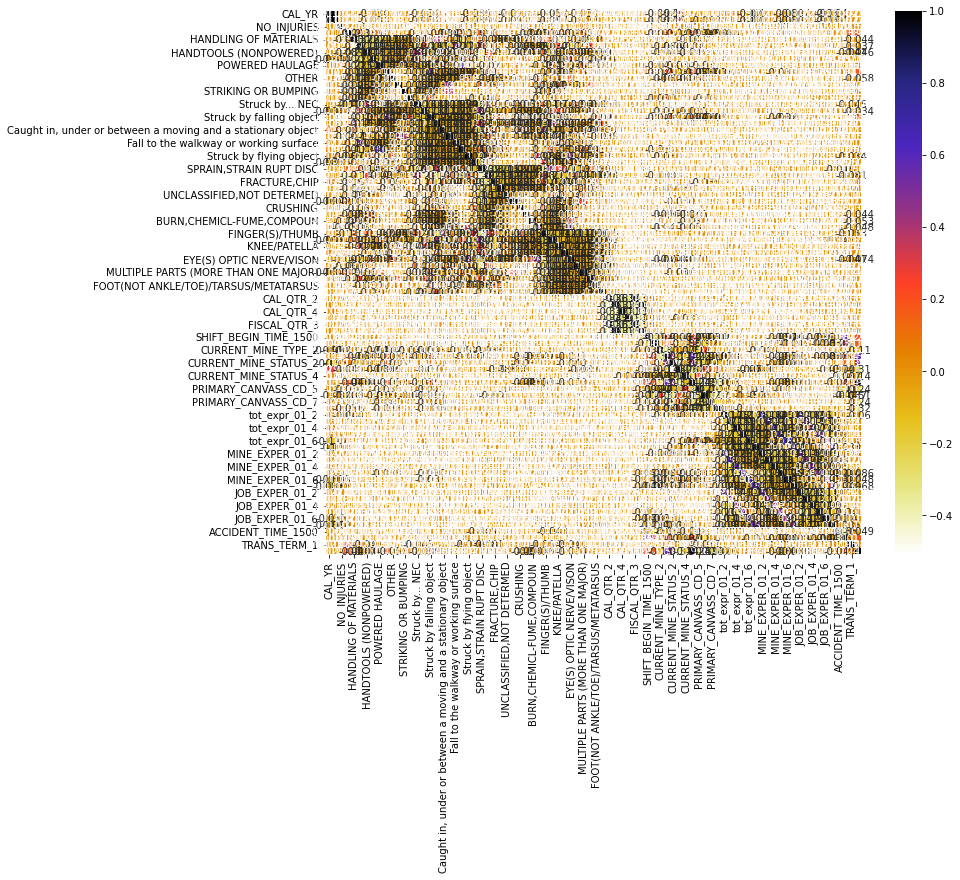

In [159]:

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [160]:
#removing due to multi collinearity
DF_13.drop(columns=['CAL_YR'], axis=1,inplace=True)

**C. Stastical analysis**

In [161]:
list_Indpndt_features = [feature for feature in DF_13.columns if 'DEGREE_INJURY_CD' not in feature ]

In [162]:
#Assumptions of Dependent and Independent Features
#Null Hypothesis 1 : - The Independent features are Highly corelated with each othe
for i in range (0,len(list_Indpndt_features)):
    for j in range (i+1 , len(list_Indpndt_features)):
        correlation  = X_train[list_Indpndt_features[i]].corr(X_train[list_Indpndt_features[j]])
        if (correlation>=0.5):
            print( list_Indpndt_features[i],' & ', list_Indpndt_features[j] , " = " , correlation)

POWERED HAULAGE  &  Struck against a moving object  =  0.6016239702844102
CAL_QTR_2  &  FISCAL_QTR_3  =  1.0
CAL_QTR_3  &  FISCAL_QTR_4  =  1.0
SHIFT_BEGIN_TIME_1500  &  ACCIDENT_TIME_2300  =  0.5446546641522474
CURRENT_MINE_TYPE_3  &  PRIMARY_CANVASS_CD_2  =  0.5657425437299131
CURRENT_MINE_TYPE_3  &  COAL_METAL_IND_1  =  0.5565336495750715
PRIMARY_CANVASS_CD_2  &  COAL_METAL_IND_1  =  0.986231649023215
tot_expr_01_2  &  MINE_EXPER_01_2  =  0.6268865411489977
tot_expr_01_2  &  JOB_EXPER_01_2  =  0.5553668094952151
tot_expr_01_3  &  MINE_EXPER_01_3  =  0.5865597978585478
tot_expr_01_4  &  MINE_EXPER_01_4  =  0.5973354860164507
tot_expr_01_5  &  MINE_EXPER_01_5  =  0.5842000123551887
tot_expr_01_6  &  MINE_EXPER_01_6  =  0.6165914090103872
tot_expr_01_7  &  MINE_EXPER_01_7  =  0.5772714565155073
tot_expr_01_7  &  JOB_EXPER_01_7  =  0.5287528266796706
MINE_EXPER_01_2  &  JOB_EXPER_01_2  =  0.5249893498533288


In [163]:
#Assumptions of Dependent and Independent Features
#Null Hypothesis 1 : - The Independent features are Highly corelated with each othe
for i in range (0,len(list_Indpndt_features)):
    for j in range (i+1 , len(list_Indpndt_features)):
        correlation  = X_train[list_Indpndt_features[i]].corr(X_train[list_Indpndt_features[j]])
        if (correlation<=-0.5):
            print( list_Indpndt_features[i],' & ', list_Indpndt_features[j] , " = " , correlation)

PRIMARY_CANVASS_CD_2  &  PRIMARY_CANVASS_CD_6  =  -0.501453787901085
PRIMARY_CANVASS_CD_6  &  COAL_METAL_IND_1  =  -0.5084543660688009


In [164]:
DF_drop =DF_13.copy()

In [165]:
#dropping the columns itteratively checking the highly correlated(>0.7) and hight VIF(>5)

DF_drop.drop(columns=['CAL_QTR_2','CAL_QTR_3','CAL_QTR_4','tot_expr_01_2','tot_expr_01_3','tot_expr_01_4','tot_expr_01_5','tot_expr_01_6','tot_expr_01_7',
                   'COAL_METAL_IND_1'], axis=1,inplace=True)

In [166]:
list_Indpndt_features = [feature for feature in DF_drop.columns if 'DEGREE_INJURY_CD' not in feature ]

In [167]:
#Assumptions of Dependent and Independent Features
#Null Hypothesis 1 : - The Independent features are Highly corelated with each othe
for i in range (0,len(list_Indpndt_features)):
    for j in range (i+1 , len(list_Indpndt_features)):
        correlation  = X_train[list_Indpndt_features[i]].corr(X_train[list_Indpndt_features[j]])
        if (correlation>=0.5):
            print( list_Indpndt_features[i],' & ', list_Indpndt_features[j] , " = " , correlation)

POWERED HAULAGE  &  Struck against a moving object  =  0.6016239702844102
SHIFT_BEGIN_TIME_1500  &  ACCIDENT_TIME_2300  =  0.5446546641522474
CURRENT_MINE_TYPE_3  &  PRIMARY_CANVASS_CD_2  =  0.5657425437299131
MINE_EXPER_01_2  &  JOB_EXPER_01_2  =  0.5249893498533288


In [168]:
#Assumptions of Dependent and Independent Features
#Null Hypothesis 1 : - The Independent features are Highly corelated with each othe
for i in range (0,len(list_Indpndt_features)):
    for j in range (i+1 , len(list_Indpndt_features)):
        correlation  = X_train[list_Indpndt_features[i]].corr(X_train[list_Indpndt_features[j]])
        if (correlation<=-0.5):
            print( list_Indpndt_features[i],' & ', list_Indpndt_features[j] , " = " , correlation)

PRIMARY_CANVASS_CD_2  &  PRIMARY_CANVASS_CD_6  =  -0.501453787901085


In [169]:
pd.set_option('display.max_rows', None)

In [170]:
##check for multi collinearity 

vif_data = pd.DataFrame() 
vif_data["feature"] =X_train[list_Indpndt_features].columns
  
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train[list_Indpndt_features].values, i)
                          for i in range(len(X_train[list_Indpndt_features].columns))]
  
print(vif_data)

                                              feature        VIF
0                                           FISCAL_YR   3.481084
1                                         NO_INJURIES   1.037925
2                                           DAYS_LOST   1.386617
3                               HANDLING OF MATERIALS  15.609742
4                              SLIP OR FALL OF PERSON  10.008290
5                              HANDTOOLS (NONPOWERED)   6.609707
6                                           MACHINERY   5.968881
7                                     POWERED HAULAGE   5.072341
8                                FALL OF ROOF OR BACK   2.538198
9                                               OTHER   2.031366
10                     STEPPING OR KNEELING ON OBJECT   2.150869
11                                STRIKING OR BUMPING   1.680637
12              FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL   1.383454
13                                   Struck by... NEC   3.008983
14                       

In [171]:
#many values has the VIF value more than 5 lets remove the bigger one and do analysis
#dropping the columns itteratively checking the highly correlated(>0.7) and hight VIF(>5)

DF_drop.drop(columns=['PRIMARY_CANVASS_CD_2', 'HANDLING OF MATERIALS'], axis=1,inplace=True)


In [172]:
list_Indpndt_features = [feature for feature in DF_drop.columns if 'DEGREE_INJURY_CD' not in feature ]

In [173]:
#

vif_data = pd.DataFrame() 
vif_data["feature"] =X_train[list_Indpndt_features].columns
  
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train[list_Indpndt_features].values, i)
                          for i in range(len(X_train[list_Indpndt_features].columns))]
  
print(vif_data)

                                              feature       VIF
0                                           FISCAL_YR  3.362580
1                                         NO_INJURIES  1.026978
2                                           DAYS_LOST  1.383397
3                              SLIP OR FALL OF PERSON  2.835809
4                              HANDTOOLS (NONPOWERED)  1.628131
5                                           MACHINERY  1.504011
6                                     POWERED HAULAGE  2.002721
7                                FALL OF ROOF OR BACK  1.492781
8                                               OTHER  1.167394
9                      STEPPING OR KNEELING ON OBJECT  1.495613
10                                STRIKING OR BUMPING  1.259504
11              FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL  1.090277
12                                   Struck by... NEC  2.837827
13                                  Over-exertion NEC  2.052326
14                           Struck by f

In [174]:
#many values has the VIF value more than 5 lets remove the bigger one and do analysis
#dropping the columns itteratively checking the highly correlated(>0.7) and hight VIF(>5)

DF_drop.drop(columns=['SPRAIN,STRAIN RUPT DISC','CUT,LACER,PUNCT-OPN WOUND'], axis=1,inplace=True)


In [175]:
list_Indpndt_features = [feature for feature in DF_drop.columns if 'DEGREE_INJURY_CD' not in feature ]

In [176]:
#

vif_data = pd.DataFrame() 
vif_data["feature"] =X_train[list_Indpndt_features].columns
  
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train[list_Indpndt_features].values, i)
                          for i in range(len(X_train[list_Indpndt_features].columns))]
  
print(vif_data)

                                              feature       VIF
0                                           FISCAL_YR  3.322393
1                                         NO_INJURIES  1.026460
2                                           DAYS_LOST  1.375644
3                              SLIP OR FALL OF PERSON  2.588969
4                              HANDTOOLS (NONPOWERED)  1.596724
5                                           MACHINERY  1.493636
6                                     POWERED HAULAGE  1.993326
7                                FALL OF ROOF OR BACK  1.490585
8                                               OTHER  1.163776
9                      STEPPING OR KNEELING ON OBJECT  1.472996
10                                STRIKING OR BUMPING  1.257892
11              FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL  1.088876
12                                   Struck by... NEC  2.319353
13                                  Over-exertion NEC  1.860441
14                           Struck by f

In [177]:
#all VIF score are well with in limit

In [178]:
pd.set_option('display.max_rows', 15)

In [179]:
DF_14 =DF_drop.copy()

In [180]:
DF_14

,FISCAL_YR,DEGREE_INJURY_CD,NO_INJURIES,DAYS_LOST,SLIP OR FALL OF PERSON,HANDTOOLS (NONPOWERED),MACHINERY,POWERED HAULAGE,FALL OF ROOF OR BACK,OTHER,...,MINE_EXPER_01_7,JOB_EXPER_01_2,JOB_EXPER_01_3,JOB_EXPER_01_4,JOB_EXPER_01_5,JOB_EXPER_01_6,JOB_EXPER_01_7,ACCIDENT_TIME_1500,ACCIDENT_TIME_2300,TRANS_TERM_1
0,2013,6,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,2006,6,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2006,6,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2009,6,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,2010,4,1,366,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181346,2006,4,2,51,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181347,2007,4,1,17,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
181348,2007,4,1,7,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
181349,2007,4,1,127,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
#IT IS difficult to do remove the columns per correlation only, 
#best bet for now would be the RFE to select top best and run through the analysis

Before moving further RFE is also a modeling where it selects the top features for the analysis to do so we have to normalize the data

# Normalization 

In [182]:
#there is a presence of skewness, data needs transformation
from scipy import stats
from pylab import *
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stats.probplot(df[feature],dist='norm',plot=plt)
    plt.show()

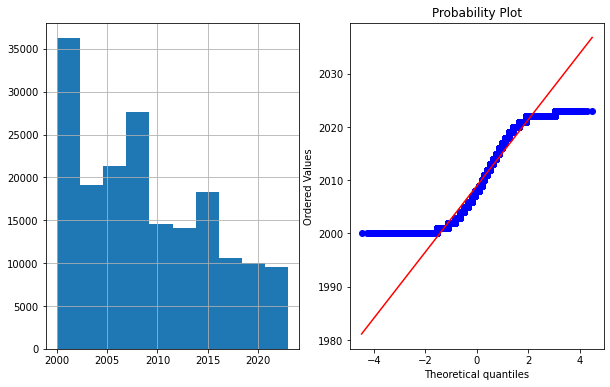

In [183]:
plot_data(DF_14,'FISCAL_YR')

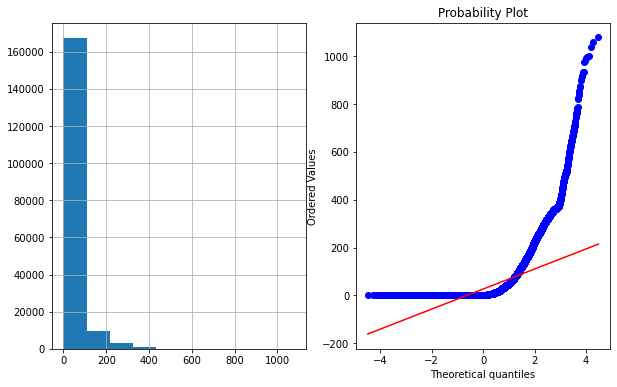

In [184]:
plot_data(DF_14,'DAYS_LOST')

In [185]:
DF_15 = DF_14.copy()

In [186]:
DF_15.columns

Index(['FISCAL_YR', 'DEGREE_INJURY_CD', 'NO_INJURIES', 'DAYS_LOST',
       'SLIP OR FALL OF PERSON', 'HANDTOOLS (NONPOWERED)', 'MACHINERY',
       'POWERED HAULAGE', 'FALL OF ROOF OR BACK', 'OTHER',
       'STEPPING OR KNEELING ON OBJECT', 'STRIKING OR BUMPING',
       'FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL', 'Struck by... NEC',
       'Over-exertion NEC', 'Struck by falling object',
       'Over-exertion in lifting objects',
       'Caught in, under or between a moving and a stationary object',
       'Struck against stationary object',
       'Fall to the walkway or working surface',
       'Struck against a moving object', 'Struck by flying object',
       'Caught in, under or between NEC', 'FRACTURE,CHIP',
       'CONTUSN,BRUISE,INTAC SKIN', 'UNCLASSIFIED,NOT DETERMED',
       'MULTIPLE INJURIES', 'CRUSHING', 'BURN OR SCALD (HEAT)',
       'BURN,CHEMICL-FUME,COMPOUN', 'DUST IN EYES', 'FINGER(S)/THUMB',
       'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)', 'KNEE/PATELLA',
       'SHOULDERS

In [187]:
#using boxcox to scale the continious column
from scipy.special import boxcox1p

df_boxcox = DF_15.apply(lambda x: boxcox1p(x,0.25))

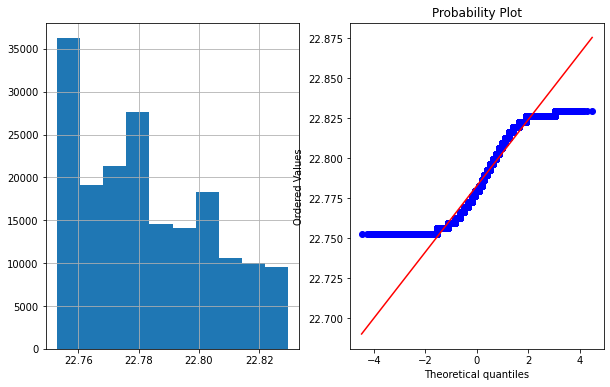

In [188]:
#prob plot
plot_data(df_boxcox,'FISCAL_YR')

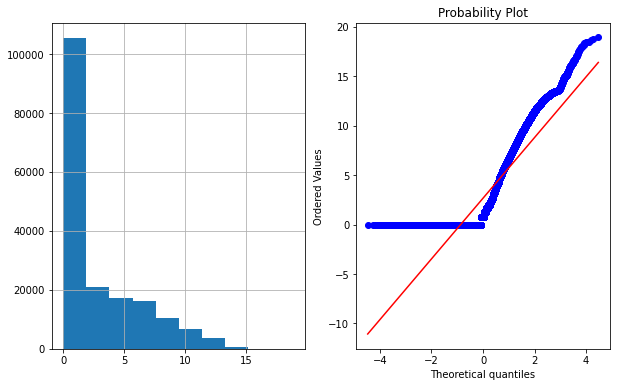

In [189]:
plot_data(df_boxcox,'DAYS_LOST')

In [190]:
df_boxcox

,FISCAL_YR,DEGREE_INJURY_CD,NO_INJURIES,DAYS_LOST,SLIP OR FALL OF PERSON,HANDTOOLS (NONPOWERED),MACHINERY,POWERED HAULAGE,FALL OF ROOF OR BACK,OTHER,...,MINE_EXPER_01_7,JOB_EXPER_01_2,JOB_EXPER_01_3,JOB_EXPER_01_4,JOB_EXPER_01_5,JOB_EXPER_01_6,JOB_EXPER_01_7,ACCIDENT_TIME_1500,ACCIDENT_TIME_2300,TRANS_TERM_1
0,22.796302,2.506306,0.756828,0.000000,0.756828,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.756828,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.756828,0.0
1,22.772987,2.506306,0.756828,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.756828,0.000000,0.0,0.000000,0.0,0.000000,0.756828,0.000000,0.000000,0.0
2,22.772987,2.506306,0.756828,0.000000,0.000000,0.756828,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.756828,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,22.782987,2.506306,0.756828,0.000000,0.756828,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.756828,0.000000,0.756828,0.000000,0.0
4,22.786317,1.981395,0.756828,13.507596,0.756828,0.000000,0.000000,0.000000,0.0,0.0,...,0.756828,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181346,22.772987,1.981395,1.264296,6.741398,0.000000,0.756828,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
181347,22.776322,1.981395,0.756828,4.239069,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.756828,0.000000,0.000000,0.000000,0.0
181348,22.776322,1.981395,0.756828,2.727171,0.000000,0.000000,0.756828,0.000000,0.0,0.0,...,0.756828,0.756828,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
181349,22.776322,1.981395,0.756828,9.454343,0.000000,0.000000,0.000000,0.756828,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [191]:
DF_15.columns

Index(['FISCAL_YR', 'DEGREE_INJURY_CD', 'NO_INJURIES', 'DAYS_LOST',
       'SLIP OR FALL OF PERSON', 'HANDTOOLS (NONPOWERED)', 'MACHINERY',
       'POWERED HAULAGE', 'FALL OF ROOF OR BACK', 'OTHER',
       'STEPPING OR KNEELING ON OBJECT', 'STRIKING OR BUMPING',
       'FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL', 'Struck by... NEC',
       'Over-exertion NEC', 'Struck by falling object',
       'Over-exertion in lifting objects',
       'Caught in, under or between a moving and a stationary object',
       'Struck against stationary object',
       'Fall to the walkway or working surface',
       'Struck against a moving object', 'Struck by flying object',
       'Caught in, under or between NEC', 'FRACTURE,CHIP',
       'CONTUSN,BRUISE,INTAC SKIN', 'UNCLASSIFIED,NOT DETERMED',
       'MULTIPLE INJURIES', 'CRUSHING', 'BURN OR SCALD (HEAT)',
       'BURN,CHEMICL-FUME,COMPOUN', 'DUST IN EYES', 'FINGER(S)/THUMB',
       'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)', 'KNEE/PATELLA',
       'SHOULDERS

In [192]:
#concat only continious column with the main data frame as rest of does not need the transformation as they are 0 and 1 values
DF_15=pd.concat([DF_15[['DEGREE_INJURY_CD',
       'SLIP OR FALL OF PERSON', 'HANDTOOLS (NONPOWERED)', 'MACHINERY',
       'POWERED HAULAGE', 'FALL OF ROOF OR BACK', 'OTHER',
       'STEPPING OR KNEELING ON OBJECT', 'STRIKING OR BUMPING',
       'FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL', 'Struck by... NEC',
       'Over-exertion NEC', 'Struck by falling object',
       'Over-exertion in lifting objects',
       'Caught in, under or between a moving and a stationary object',
       'Struck against stationary object',
       'Fall to the walkway or working surface',
       'Struck against a moving object', 'Struck by flying object',
       'Caught in, under or between NEC', 'FRACTURE,CHIP',
       'CONTUSN,BRUISE,INTAC SKIN', 'UNCLASSIFIED,NOT DETERMED',
       'MULTIPLE INJURIES', 'CRUSHING', 'BURN OR SCALD (HEAT)',
       'BURN,CHEMICL-FUME,COMPOUN', 'DUST IN EYES', 'FINGER(S)/THUMB',
       'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)', 'KNEE/PATELLA',
       'SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA)', 'EYE(S) OPTIC NERVE/VISON',
       'HAND (NOT WRIST OR FINGERS)', 'MULTIPLE PARTS (MORE THAN ONE MAJOR)',
       'ANKLE', 'FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS',
       'HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)', 'FISCAL_QTR_2', 'FISCAL_QTR_3',
       'FISCAL_QTR_4', 'SHIFT_BEGIN_TIME_1500', 'SHIFT_BEGIN_TIME_2300',
       'CURRENT_MINE_TYPE_2', 'CURRENT_MINE_TYPE_3', 'CURRENT_MINE_STATUS_2',
       'CURRENT_MINE_STATUS_3', 'CURRENT_MINE_STATUS_4',
       'PRIMARY_CANVASS_CD_5', 'PRIMARY_CANVASS_CD_6', 'PRIMARY_CANVASS_CD_7',
       'PRIMARY_CANVASS_CD_8', 'MINE_EXPER_01_2', 'MINE_EXPER_01_3',
       'MINE_EXPER_01_4', 'MINE_EXPER_01_5', 'MINE_EXPER_01_6',
       'MINE_EXPER_01_7', 'JOB_EXPER_01_2', 'JOB_EXPER_01_3', 'JOB_EXPER_01_4',
       'JOB_EXPER_01_5', 'JOB_EXPER_01_6', 'JOB_EXPER_01_7',
       'ACCIDENT_TIME_1500', 'ACCIDENT_TIME_2300', 'TRANS_TERM_1']],df_boxcox[['FISCAL_YR', 'NO_INJURIES','DAYS_LOST']]], axis=1)
DF_15

,DEGREE_INJURY_CD,SLIP OR FALL OF PERSON,HANDTOOLS (NONPOWERED),MACHINERY,POWERED HAULAGE,FALL OF ROOF OR BACK,OTHER,STEPPING OR KNEELING ON OBJECT,STRIKING OR BUMPING,FALL OF FACE/RIB/PILLAR/SIDE/HIGHWALL,...,JOB_EXPER_01_4,JOB_EXPER_01_5,JOB_EXPER_01_6,JOB_EXPER_01_7,ACCIDENT_TIME_1500,ACCIDENT_TIME_2300,TRANS_TERM_1,FISCAL_YR,NO_INJURIES,DAYS_LOST
0,6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,22.796302,0.756828,0.000000
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,22.772987,0.756828,0.000000
2,6,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,22.772987,0.756828,0.000000
3,6,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,22.782987,0.756828,0.000000
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,22.786317,0.756828,13.507596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181346,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,22.772987,1.264296,6.741398
181347,4,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,22.776322,0.756828,4.239069
181348,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,22.776322,0.756828,2.727171
181349,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,22.776322,0.756828,9.454343


# Step 4: Exporting data into the excel for the modeling 

In [193]:
x = pd.DataFrame(DF_15)
x.to_excel(excel_writer = r'/content/gdrive/MyDrive/research_threecat__12_34_56.xlsx')